In [ ]:
## Paste code in conda terminal
# conda activate prophet_env
# jupyter notebook

In [1]:
from random import gauss as gs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
from varname import nameof


#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima   
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
pd.plotting.register_matplotlib_converters()
from statsmodels.tools.eval_measures import rmse


import os, sys
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Data

The original data is gathered from [Zillow](https://www.zillow.com/research/data/). The dataframe contains the ZHVI for single family homes from every zipcode in the US from 1/31/1996 to 2/28/2021 on a monthly interval. The Zillow Home Value Index (ZHVI) is a smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. 



In [474]:
import os

In [475]:
os.getcwd()

'C:\\Users\\rsingh\\Downloads'

In [476]:
#df = pd.read_csv('Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_mon.csv')
df = pd.read_csv('Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [477]:
df.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  208752.177188   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  133799.965954   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  102327.332899   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  147672.475058   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  100957.722364   

   ...     2023-03-31     2023-04-30     2023-05-31     2023-06-30  \
0  ...  468400.012962  469600.790271  471587.869725  474687.471351   
1  ...  517054.419786  521100.063176  526320.736228  532105.809020   
2  ...  274575.011824  273391.851083  272916.706411  273291.932508   
3  ...  480340.864596  473730.902787  466644.010241  461261.507623   
4  ...  267553.019024  266769.398609  266628.259422  267219.988459   

      2023-07-31     2023-08-31     2023-09-30     2023-10-31     2023-11-30  \
0  477460.027392  479919.299106  481726.908022  482958.479293  483644.390919   
1  538056.023382  543798.549494  549960.546654  557112.585902  563739.635747   
2  274045.370378  274933.235990  275461.772882  275451.663963  275219.130604   
3  459443.414913  459437.482269  458881.548977  456860.171677  453514.767036   
4  268054.762069  268918.974834  269342.669492  269333.119699  268917.017812   

      2023-12-31  
0  484254.484150  
1  568385.787815  
2  274931.001539  
3  449239.710048  
4  268499.368493  

[5 rows x 297 columns]

In [6]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
       '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
      dtype='object', length=297)

In [7]:
df.iloc[:,1:10]

SizeRank  RegionName RegionType StateName State         City  \
0             1       77494        zip        TX    TX         Katy   
1             2        8701        zip        NJ    NJ     Lakewood   
2             3       77449        zip        TX    TX         Katy   
3             4       11368        zip        NY    NY     New York   
4             5       77084        zip        TX    TX      Houston   
...         ...         ...        ...       ...   ...          ...   
26349     39992       22731        zip        VA    VA        Aroda   
26350     39992       46799        zip        IN    IN   Zanesville   
26351     39992       52163        zip        IA    IA     Protivin   
26352     39992       26576        zip        WV    WV   Farmington   
26353     39992       50160        zip        IA    IA  Martensdale   

                                              Metro        CountyName  \
0              Houston-The Woodlands-Sugar Land, TX  Fort Bend County   
1             New York-Newark-Jersey City, NY-NJ-PA      Ocean County   
2              Houston-The Woodlands-Sugar Land, TX     Harris County   
3             New York-Newark-Jersey City, NY-NJ-PA     Queens County   
4              Houston-The Woodlands-Sugar Land, TX     Harris County   
...                                             ...               ...   
26349  Washington-Arlington-Alexandria, DC-VA-MD-WV    Madison County   
26350                                  Bluffton, IN      Wells County   
26351                                           NaN     Howard County   
26352                                  Fairmont, WV     Marion County   
26353                Des Moines-West Des Moines, IA     Warren County   

          2000-01-31  
0      208752.177188  
1      133799.965954  
2      102327.332899  
3      147672.475058  
4      100957.722364  
...              ...  
26349            NaN  
26350            NaN  
26351            NaN  
26352            NaN  
26353            NaN  

[26354 rows x 9 columns]

In [8]:
df.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     61639         0       10025        Zip        NY    NY  New York   
1     84654         1       60657        Zip        IL    IL   Chicago   
2     61637         2       10023        Zip        NY    NY  New York   
3     91982         3       77494        Zip        TX    TX      Katy   
4     84616         4       60614        Zip        IL    IL   Chicago   

                              Metro       CountyName   1/31/96  ...  5/31/20  \
0       New York-Newark-Jersey City  New York County       NaN  ...  1251067   
1          Chicago-Naperville-Elgin      Cook County  360618.0  ...   964280   
2       New York-Newark-Jersey City  New York County       NaN  ...  1533387   
3  Houston-The Woodlands-Sugar Land    Harris County  200194.0  ...   337319   
4          Chicago-Naperville-Elgin      Cook County  547552.0  ...  1204098   

   6/30/20  7/31/20  8/31/20  9/30/20  10/31/20  11/30/20  12/31/20  1/31/21  \
0  1243911  1242393  1243116  1249957   1253918   1256918   1260189  1255048   
1   964191   965875   968256   973015    978022    981918    985428   987405   
2  1534731  1533831  1534093  1534862   1541697   1549960   1557635  1558745   
3   338148   338871   340299   341862    344329    347347    351632   355788   
4  1205314  1208072  1211021  1216680   1222663   1228051   1233108  1236396   

   2/28/21  
0  1247237  
1   991571  
2  1558968  
3   360651  
4  1243489  

[5 rows x 311 columns]

The below function filters for row with for the relevant zipcode, takes the row and reformats it so that is suitable for time series analysis. I am adding an exogenous variable, the financial crisi flag, to account for the price trend changing during the Great Recession. 

In [14]:
def format_df(df, zip_code):
    df = df[df['RegionName'] == zip_code]
    df = df.iloc[:,9:].transpose()
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df = df.rename(columns={df.columns[0]: 'Zillow Home Value Index (ZHVI)'})
    df.dropna(inplace = True)
    df['financial_crisis_flag'] = 0
    df.loc['2007-08-30': '2012-01-31', 'financial_crisis_flag'] = 1

    return df

The zipcodes that were requested are as follows:  
23060 contains of the towns of Glen Allen and Innsbrook, suburbs of Richmond  
23226 contains the West End of the city  
23221 contains Carrytown, the Museum District, and Windsor Farms, thriving cultural areas of the city and adjacent suburbs.  
23220 contains the Fan District a central urban neighborhood where VCU is located, and surrounding areas.  
23227 contains the neighborhood of Bellevue, a picturesque area just outside the city and the town of Chamberlayne.  
![image](images/richmond_zipcodes.png)



In [324]:
z23060.tail()

Zillow Home Value Index (ZHVI)  financial_crisis_flag
2023-08-31                   401697.250270                      0
2023-09-30                   404834.836102                      0
2023-10-31                   407219.806150                      0
2023-11-30                   408973.633817                      0
2023-12-31                   410534.627066                      0

In [276]:
z23060 = format_df(df, 23060)
z23226 = format_df(df, 23226)
z23221 = format_df(df, 23221)
z23220 = format_df(df, 23220)
z23224 = format_df(df, 23224)

In [293]:
## Ensuring the financial crisis flag on covid times + 2008 housing crisis
z23060[z23060['financial_crisis_flag']==1].index

DatetimeIndex(['2007-08-31', '2007-09-30', '2007-10-31', '2007-11-30',
               '2007-12-31', '2008-01-31', '2008-02-29', '2008-03-31',
               '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31',
               '2008-08-31', '2008-09-30', '2008-10-31', '2008-11-30',
               '2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31',
               '2009-04-30', '2009-05-31', '2009-06-30', '2009-07-31',
               '2009-08-31', '2009-09-30', '2009-10-31', '2009-11-30',
               '2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30',
               '2011-12-31', '2012-01-31', '2020-03-31', '2020-04-30',
      

## Facebook Prophet Modeling

Facebook 'Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.'

I will use Facebook Prophet to model and forecast the data. I will see if there are different results using this implementation compared to the SARIMA models. 

Ultimately, I will combine the result from the SARIMA models and the Prophet models to make an ultimate recommendation. 

### Facebook Prophet Library
Prophet is an open-source tool from Facebook used for forecasting time series data which helps businesses understand and possibly predict the market. It is based on a decomposable additive model where non-linear trends fit with seasonality, it also takes into account the effects of holidays. Before we head right into coding, let’s learn certain terms that are required to understand this. 

Trend: The trend shows the tendency of the data to increase or decrease over a long period of time and it filters out the seasonal variations. 
Seasonality: Seasonality is the variations that occur over a short period of time and is not prominent enough to be called a “trend”. 
Understanding the Prophet Model 
The general idea of the model is similar to a generalized additive model. The “Prophet Equation” fits, as mentioned above, trends, seasonality, and holidays. This is given by,

y(t) = g(t) + s(t) + h(t) + e(t)

where,


g(t) refers to trend (changes over a long period of time)
s(t) refers to seasonality (periodic or short term changes)
h(t) refers to effects of holidays to the forecast
e(t) refers to the unconditional changes that is specific to a business or a person or a circumstance. It is also called the error term.
y(t) is the forecast.

### Why do we need a tool like Prophet to help us with forecasting?
We need it because, although the basic decomposable additive model looks simple, the calculation of the terms within is hugely mathematical. If you do not know what you are doing, it may lead to making wrong forecasts, which might have severe repercussions in the real world. So to automate this process, we are going to use Prophet. However, to understand the math behind this process and how Prophet actually works, let’s see how it forecasts the data. 

Prophet provides us with two models(however, newer models can be written or extended according to specific requirements). 

1. Logistic Growth Model 
2. Piece-Wise Linear Model

By default, Prophet uses a piece-wise linear model, but it can be changed by specifying the model. Choosing a model is delicate as it is dependent on a variety of factors such as company size, growth rate, business model, etc., If the data to be forecasted, has saturating and non-linear data(grows non-linearly and after reaching the saturation point, shows little to no growth or shrink and only exhibits some seasonal changes), then logistic growth model is the best option. Nevertheless, if the data shows linear properties and had growth or shrink trends in the past then, the piece-wise linear model is a better choice. 

In [29]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [30]:
def df_to_prophet(df):
    new = df.reset_index()
    new.rename(columns = {'index' : 'ds', 'Zillow Home Value Index (ZHVI)': 'y'}, inplace = True)
    return new

In [31]:
def prophet_model(df):
    new_df = df_to_prophet(df)
    model = Prophet(changepoint_range= 1, changepoint_prior_scale=0.08)
    model.fit(new_df)
    future = model.make_future_dataframe(periods = 12, freq = 'M')
    forecast = model.predict(future)
    return model, forecast




In [32]:
z23220_prophet_model, z23220_prophet_forecast = prophet_model(z23220)

21:37:53 - cmdstanpy - INFO - Chain [1] start processing
21:37:53 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
z23221_prophet_model, z23221_prophet_forecast = prophet_model(z23221)

21:37:57 - cmdstanpy - INFO - Chain [1] start processing
21:37:57 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
z23060_prophet_model, z23060_prophet_forecast = prophet_model(z23060)

21:37:58 - cmdstanpy - INFO - Chain [1] start processing
21:37:59 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
z23226_prophet_model, z23226_prophet_forecast = prophet_model(z23226)

21:38:00 - cmdstanpy - INFO - Chain [1] start processing
21:38:00 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
z23227_prophet_model, z23227_prophet_forecast = prophet_model(z23227)

21:38:01 - cmdstanpy - INFO - Chain [1] start processing
21:38:01 - cmdstanpy - INFO - Chain [1] done processing


I can see from the below charts and results that the forecasts from the Facebook Prophet models are more conservative than from the SARIMA models.

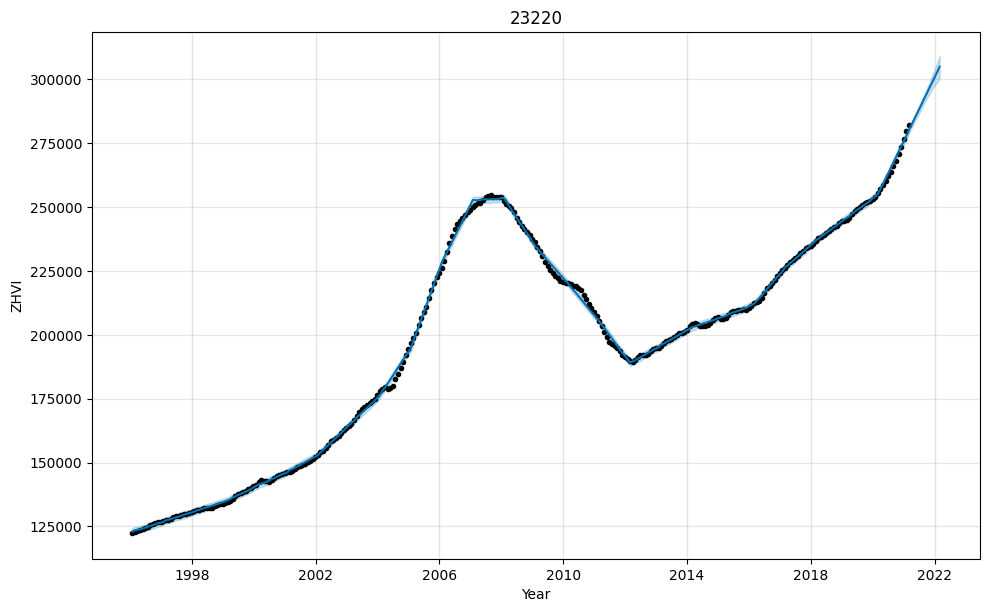

In [37]:
fig = z23220_prophet_model.plot(z23220_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax = fig.gca()
ax.set_title("23220")
plt.show()

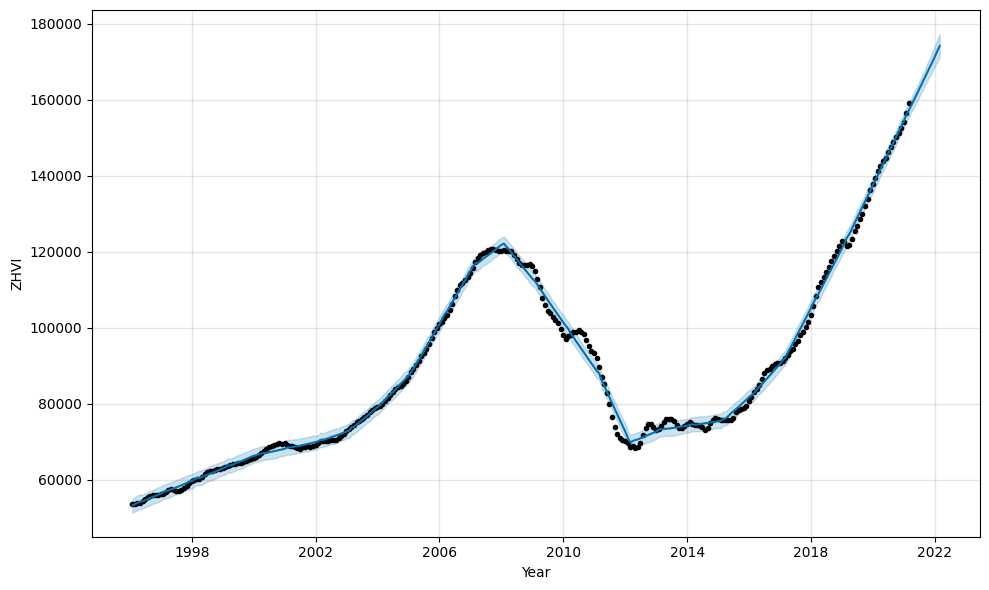

In [38]:
fig2 = z23221_prophet_model.plot(z23221_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax2 = fig.gca()
ax2.set_title("23221")
plt.show()

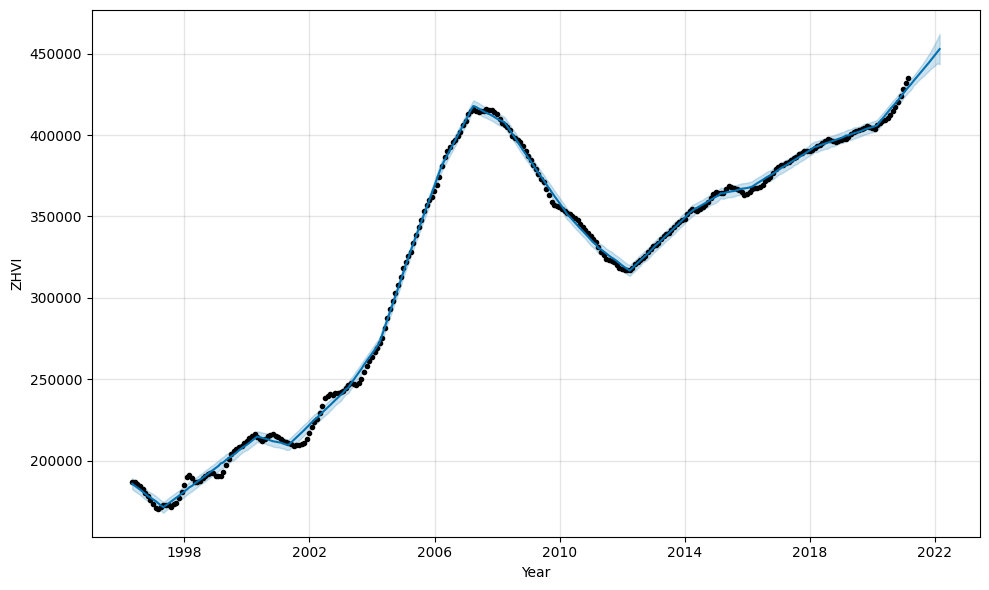

In [39]:
fig3 = z23060_prophet_model.plot(z23060_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax3 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23060_prophet_model, z23060_prophet_forecast)
plt.show()

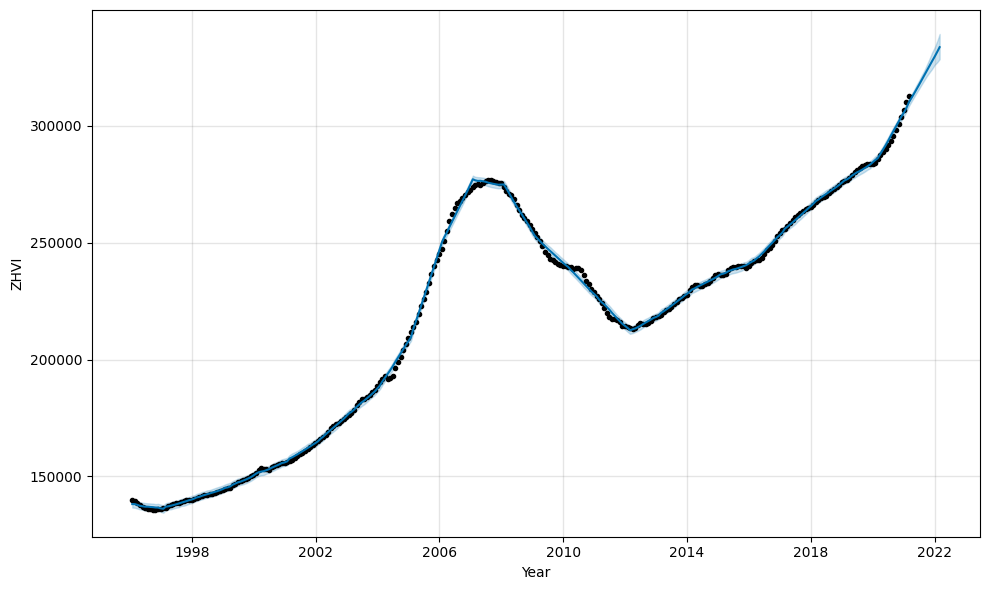

In [40]:
fig4 = z23226_prophet_model.plot(z23226_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax4 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23226_prophet_model, z23226_prophet_forecast)


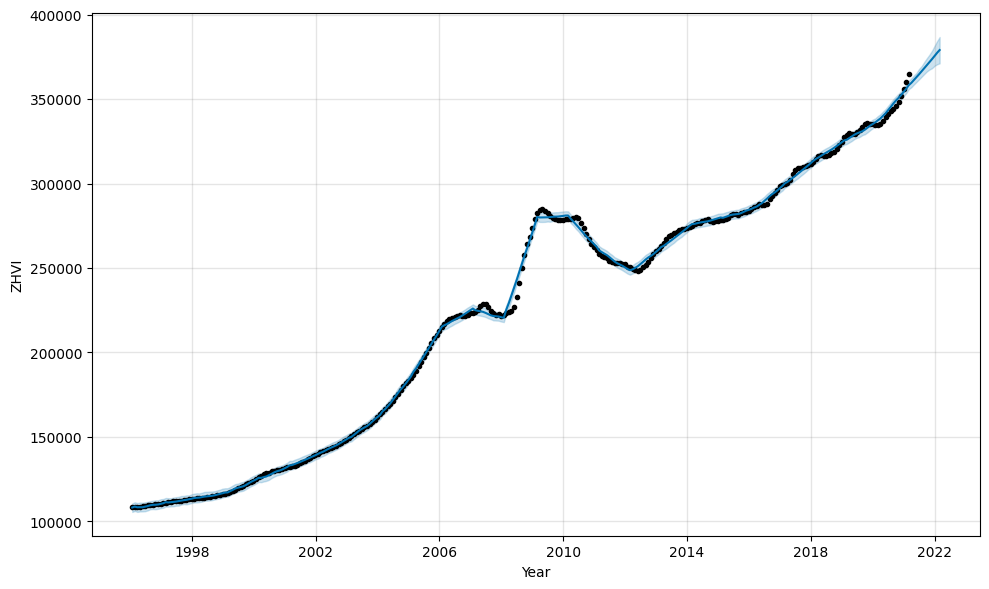

In [41]:
fig5 = z23227_prophet_model.plot(z23227_prophet_forecast, xlabel = 'Year', ylabel = 'ZHVI', uncertainty = True )
ax5 = fig.gca()
a = add_changepoints_to_plot(fig.gca(), z23227_prophet_model, z23227_prophet_forecast)

In [43]:
z23060_prophet_forecast

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   1996-04-30  185783.779449  182603.795702  189370.853028  185783.779449   
1   1996-05-31  184561.501201  181290.241678  187957.946411  184561.501201   
2   1996-06-30  183378.651283  180249.273715  186873.587999  183378.651283   
3   1996-07-31  182156.373034  179159.393042  185761.935146  182156.373034   
4   1996-08-31  180934.094786  177666.630629  184454.052989  180934.094786   
..         ...            ...            ...            ...            ...   
306 2021-10-31  444775.027880  439770.148557  449936.995081  441217.539347   
307 2021-11-30  446683.286116  441149.903700  452767.103652  442160.380148   
308 2021-12-31  448655.152959  442453.758672  455747.989496  442863.330496   
309 2022-01-31  450627.019803  443968.668351  458944.344111  443965.773650   
310 2022-02-28  452408.060822  443502.888023  462042.545768  444610.579614   

       trend_upper  additive_terms  additive_terms_lower  \
0    185783.779449      136.723695            136.723695   
1    184561.501201      104.198090            104.198090   
2    183378.651283      181.754586            181.754586   
3    182156.373034      199.453023            199.453023   
4    180934.094786      131.759780            131.759780   
..             ...             ...                   ...   
306  448936.141222       -5.034808             -5.034808   
307  451816.082200       61.978316             61.978316   
308  454871.648411      118.273481            118.273481   
309  458219.932912      181.768109            181.768109   
310  461214.451109      354.078349            354.078349   

     additive_terms_upper      yearly  yearly_lower  yearly_upper  \
0              136.723695  136.723695    136.723695    136.723695   
1              104.198090  104.198090    104.198090    104.198090   
2              181.754586  181.754586    181.754586    181.754586   
3              199.453023  199.453023    199.453023    199.453023   
4              131.759780  131.759780    131.759780    131.759780   
..                    ...         ...           ...           ...   
306             -5.034808   -5.034808     -5.034808     -5.034808   
307             61.978316   61.978316     61.978316     61.978316   
308            118.273481  118.273481    118.273481    118.273481   
309            181.768109  181.768109    181.768109    181.768109   
310            354.078349  354.078349    354.078349    354.078349   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
306                   0.0                         0.0   
307                   0.0                         0.0   
308                   0.0                         0.0   
309                   0.0                         0.0   
310                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
0                           0.0  185920.503144  
1                           0.0  184665.699290  
2                           0.0  183560.405869  
3                           0.0  182355.826057  
4                           0.0  181065.854566  
..                          ...            ...  
306                         0.0  444769.993072  
307                         0.0  446745.264432  
308                         0.0  448773.426441  
309                         0.0  450808.787911  
310                         0.0  452762.139172  

[311 rows x 16 columns]

In [48]:
z23060_prophet_forecast.loc[310,'yhat']

452762.13917159644

In [ ]:
z23060_prophet_forecast_returns = (z23060_prophet_forecast.loc[312,'yhat'] - z23060['Zillow Home Value Index (ZHVI)'][-1]) / z23060['Zillow Home Value Index (ZHVI)'][-1]

In [49]:
z23060_prophet_forecast_returns = (z23060_prophet_forecast.loc[310,'yhat'] - z23060['Zillow Home Value Index (ZHVI)'][-1]) / z23060['Zillow Home Value Index (ZHVI)'][-1]
z23220_prophet_forecast_returns = (z23220_prophet_forecast.loc[310,'yhat'] - z23220['Zillow Home Value Index (ZHVI)'][-1]) / z23220['Zillow Home Value Index (ZHVI)'][-1]
z23221_prophet_forecast_returns = (z23221_prophet_forecast.loc[310,'yhat'] - z23221['Zillow Home Value Index (ZHVI)'][-1]) / z23221['Zillow Home Value Index (ZHVI)'][-1]
z23226_prophet_forecast_returns = (z23226_prophet_forecast.loc[310,'yhat'] - z23226['Zillow Home Value Index (ZHVI)'][-1]) / z23226['Zillow Home Value Index (ZHVI)'][-1]
z23227_prophet_forecast_returns = (z23227_prophet_forecast.loc[310,'yhat'] - z23227['Zillow Home Value Index (ZHVI)'][-1]) / z23226['Zillow Home Value Index (ZHVI)'][-1] 
prophet_returns_dict = {'z23060' : z23060_prophet_forecast_returns*100, 'z23220' : z23220_prophet_forecast_returns*100, 'z23221': z23221_prophet_forecast_returns*100, 'z23226': z23226_prophet_forecast_returns*100, 'z23227':z23227_prophet_forecast_returns*100 }

In [50]:
prophet_returns_dict

{'z23060': 4.125618739486284,
 'z23220': 5.92803090155111,
 'z23221': 6.708416571756773,
 'z23226': 4.781031120422989,
 'z23227': 2.766075725685958}

The Facebook Prophet models forecast 23220 with the highest return of 5.77% but 23060 is very close behind with 5.67. 23227 which did best in the SARIMA modeling is 3rd with 4.95.

In [51]:
prophet_returns_df = pd.DataFrame(prophet_returns_dict.items(), columns = ['Zipcode', 'Forecast_1_Year_%_Appreciation'])
prophet_returns_df = prophet_returns_df.sort_values('Forecast_1_Year_%_Appreciation', ascending = False)
prophet_returns_df

Zipcode  Forecast_1_Year_%_Appreciation
2  z23221                        6.708417
1  z23220                        5.928031
3  z23226                        4.781031
0  z23060                        4.125619
4  z23227                        2.766076

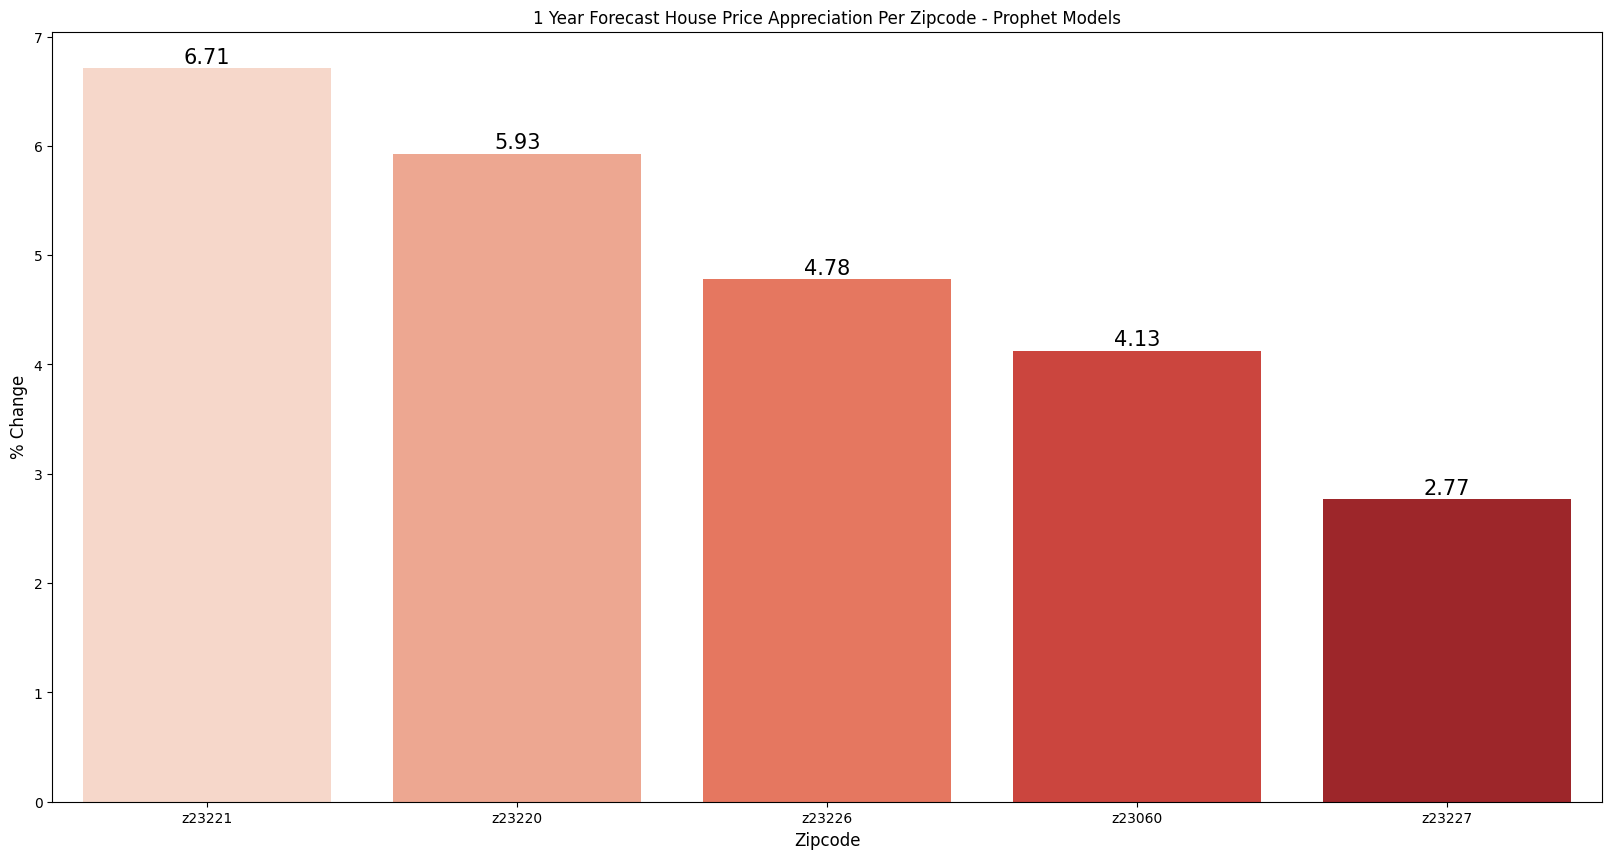

In [52]:
fig, ax = plt.subplots(figsize = (20,10))

ax = sns.barplot(x = prophet_returns_df['Zipcode'], y = prophet_returns_df['Forecast_1_Year_%_Appreciation'], orient = 'v', palette = 'Reds')
ax.set_title('1 Year Forecast House Price Appreciation Per Zipcode - Prophet Models', fontsize = 12)
ax.set_ylabel('% Change', fontsize =12)
ax.set_xlabel('Zipcode', fontsize =12)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

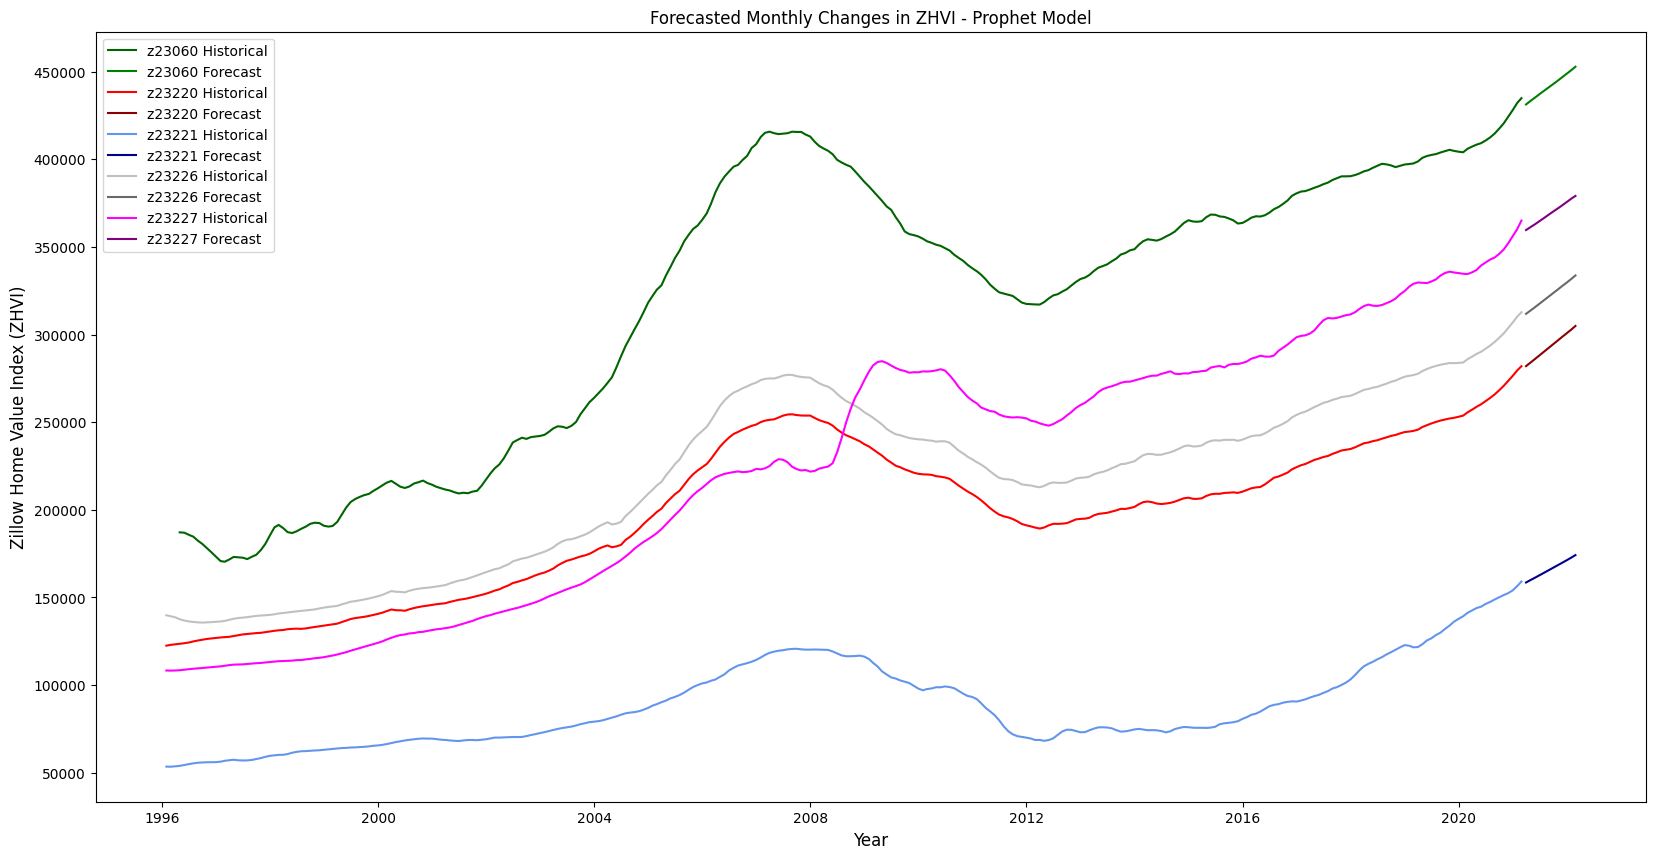

In [53]:
fig, ax = plt.subplots(figsize = (20,10))

ax.plot(z23060['Zillow Home Value Index (ZHVI)'], label='z23060 Historical', color = 'darkgreen')
ax.plot(z23060_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23060 Forecast', color = 'green')

ax.plot(z23220['Zillow Home Value Index (ZHVI)'], label='z23220 Historical', color = 'red')
ax.plot(z23220_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23220 Forecast', color = 'darkred')

ax.plot(z23221['Zillow Home Value Index (ZHVI)'], label='z23221 Historical', color = 'cornflowerblue')
ax.plot(z23221_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23221 Forecast', color = 'darkblue')

ax.plot(z23226['Zillow Home Value Index (ZHVI)'], label='z23226 Historical', color = 'silver')
ax.plot(z23226_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23226 Forecast', color = 'dimgrey')

ax.plot(z23227['Zillow Home Value Index (ZHVI)'], label='z23227 Historical', color = 'fuchsia')
ax.plot(z23227_prophet_forecast.set_index('ds').loc['2021-03-30':, 'yhat'], label='z23227 Forecast', color = 'purple')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
plt.legend()

ax.set_title(f"Forecasted Monthly Changes in ZHVI - Prophet Model");

plt.show()

In general the Prophet model predicted much lower price appreciation than the SARIMA model. It seems the SARIMA model took the most recent trend and expanded on it while the Prophet model smoothed the trend more over the entire time dataset. The large difference further justify taking the average of the two. The below chart shows the difference in the SARIMA model vs the Prophet model for 23060 and 23227

In [ ]:
## Next Steps - Automate the process - Cover entire region to make forecasts, using zipcodes. 

In [ ]:
## Lets automate Facebook Prophet Modelling for all Zipcodes

In [76]:
prophet_returns_df

Zipcode  Forecast_1_Year_%_Appreciation
1    23112                        6.042253
3    23832                        4.083290
4    23238                        3.510792
2    23224                        3.305213
0    23120                        2.214792

In [ ]:
## Third Step

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Read the shapefile
shapefile_path_bkg = 'C:\\Users\\rsingh\\OneDrive - PlanRVA\\Documents\\DataHub-Rishabh\\Default Shapefiles\\va_zipcodes\\va-Zipcodes_RTC_PlanRVA.shp'  # Update with the path to your shapefile
#Planrva_file_Above
shapefile_path = 'C:\\Users\\rsingh\\OneDrive - PlanRVA\\Documents\\DataHub-Rishabh\\Default Shapefiles\\va_zipcodes\\tl_2019_us_zcta510\\tl_2019_us_zcta510.shp'
gdf = gpd.read_file(shapefile_path)
#When Planrva is the footprint 
gdf_bkg = gpd.read_file(shapefile_path_bkg)
gdf.head()

ZCTA5CE10 GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
0     43451   43451        B5   G6350          S   63484186    157689   
1     43452   43452        B5   G6350          S  121522304  13721730   
2     43456   43456        B5   G6350          S    9320975   1003775   
3     43457   43457        B5   G6350          S   48004681         0   
4     43458   43458        B5   G6350          S    2573816     39915   

    INTPTLAT10    INTPTLON10  \
0  +41.3183010  -083.6174935   
1  +41.5157923  -082.9809454   
2  +41.6318300  -082.8393923   
3  +41.2673301  -083.4274872   
4  +41.5304461  -083.2133648   

                                            geometry  
0  POLYGON ((-83.70873 41.32733, -83.70815 41.327...  
1  POLYGON ((-83.08698 41.53780, -83.08256 41.537...  
2  MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ...  
3  POLYGON ((-83.49650 41.25371, -83.48382 41.253...  
4  POLYGON ((-83.22229 41.53102, -83.22228 41.532...

In [452]:
path1 = r"C:\Users\rsingh\OneDrive - PlanRVA\Documents\DataHub-Rishabh\Base locality Boundary\Loc_Boundary_RTC.shp"
gdf_counties = gpd.read_file(path1)

In [478]:
## PlanRVA region Zipcodes
zip_codes = gdf_bkg['GEOID10'].astype(int)

zip_codes

0     23089
1     23093
2     23102
3     23103
4     23106
      ...  
80    23038
81    23039
82    23047
83    23059
84    23060
Name: GEOID10, Length: 85, dtype: int32

In [99]:
# Rename 'old_column_name' to 'new_column_name'
gdf.rename(columns={'GEOID10': 'Zipcode'}, inplace=True)

gdf.columns

Index(['ZCTA5CE10', 'Zipcode', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

## Below code only to be used When modelling using full dataset to predict next one year till 2025. 

In [341]:
# ## When modelling using full dataset to predict next one year till 2025. 

# from prophet import Prophet
# import pandas as pd
# from datetime import datetime

# def prophet_model(full_df, zip_code):
#     new_df = df_to_prophet(full_df)
#     model = Prophet(changepoint_range=1, changepoint_prior_scale=0.08)

#     try:
#         model.fit(new_df)

#         # Calculate the number of months to forecast
#         last_date = new_df['ds'].max()
#         end_of_2025 = datetime(2025, 12, 31)
#         months_to_forecast = (end_of_2025.year - last_date.year) * 12 + end_of_2025.month - last_date.month

#         # Create future DataFrame for forecasting up to the end of 2025
#         future = model.make_future_dataframe(periods=months_to_forecast, freq='M')
#         forecast = model.predict(future)

#         return model, forecast
#     except ValueError as e:
#         print(f"Error fitting model for zip code {zip_code}: {e}")
#         return None, None


# # Dictionaries to store models and forecasts for each zip code
# prophet_models = {}
# prophet_forecasts = {}

# for zip_code in zip_codes:
#     formatted_df = format_df(df, zip_code)
#     if formatted_df is not None:
#         model, forecast = prophet_model(formatted_df, zip_code)
#         if model is not None:
#             prophet_forecasts[zip_code] = forecast
#             prophet_models[zip_code] = model
#         else:
#             print(f"Skipping zip code {zip_code} due to model fitting errors.")
#     else:
#         print(f"Skipping zip code {zip_code} due to insufficient data.")



00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing
00:21:59 - cmdstanpy - INFO - Chain [1] start processing
00:21:59 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing
00:22:00 - cmdstanpy - INFO - Chain [1] start processing
00:22:00 - cmdstanpy - INFO - Chain [1] done processing
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:01 - cmdstanpy - INFO - Chain [1] done processing
00:22:01 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1] done processing
00:22:02 - cmdstanpy - INFO - Chain [1] start processing
00:22:02 - cmdstanpy - INFO - Chain [1]

Skipping zip code 23160 due to insufficient data.
Skipping zip code 23173 due to insufficient data.


00:22:06 - cmdstanpy - INFO - Chain [1] start processing
00:22:06 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:07 - cmdstanpy - INFO - Chain [1] start processing
00:22:07 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:08 - cmdstanpy - INFO - Chain [1] done processing
00:22:08 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1] done processing
00:22:09 - cmdstanpy - INFO - Chain [1] start processing
00:22:09 - cmdstanpy - INFO - Chain [1]

Skipping zip code 23250 due to insufficient data.


00:22:12 - cmdstanpy - INFO - Chain [1] start processing
00:22:12 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:13 - cmdstanpy - INFO - Chain [1] start processing
00:22:13 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:14 - cmdstanpy - INFO - Chain [1] start processing
00:22:14 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1] done processing
00:22:15 - cmdstanpy - INFO - Chain [1] start processing
00:22:15 - cmdstanpy - INFO - Chain [1]

Skipping zip code 23801 due to insufficient data.


00:22:17 - cmdstanpy - INFO - Chain [1] done processing
00:22:17 - cmdstanpy - INFO - Chain [1] start processing
00:22:17 - cmdstanpy - INFO - Chain [1] done processing
00:22:18 - cmdstanpy - INFO - Chain [1] start processing


Skipping zip code 23806 due to insufficient data.


00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:18 - cmdstanpy - INFO - Chain [1] start processing
00:22:18 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing
00:22:19 - cmdstanpy - INFO - Chain [1] start processing
00:22:19 - cmdstanpy - INFO - Chain [1] done processing
00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:20 - cmdstanpy - INFO - Chain [1] start processing
00:22:20 - cmdstanpy - INFO - Chain [1] done processing
00:22:21 - cmdstanpy - INFO - Chain [1] 

Error fitting model for zip code 23894: Dataframe has less than 2 non-NaN rows.
Skipping zip code 23894 due to model fitting errors.


00:22:21 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:22 - cmdstanpy - INFO - Chain [1] done processing
00:22:22 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:23 - cmdstanpy - INFO - Chain [1] start processing
00:22:23 - cmdstanpy - INFO - Chain [1] done processing
00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing
00:22:24 - cmdstanpy - INFO - Chain [1] start processing
00:22:24 - cmdstanpy - INFO - Chain [1] done processing
00:22:24 - cmdstanpy - INFO - Chain [1] 

# Final Script for Facebook Prophet Model down below -

In [479]:
from prophet import Prophet
import pandas as pd

def format_df(df, zip_code):
    df_filtered = df[df['RegionName'] == zip_code]

    # Check if DataFrame is empty or does not have enough columns
    if df_filtered.empty or df_filtered.shape[1] <= 9:
        return None

    df_filtered = df_filtered.iloc[:,9:].transpose()
    df_filtered.index = pd.to_datetime(df_filtered.index, infer_datetime_format=True)

    # Check if DataFrame is empty after transpose
    if df_filtered.empty:
        return None

    df_filtered = df_filtered.rename(columns={df_filtered.columns[0]: 'Zillow Home Value Index (ZHVI)'})
    df_filtered.dropna(inplace=True)
    df_filtered['financial_crisis_flag'] = 0
    df_filtered.loc['2007-08-30': '2012-01-31', 'financial_crisis_flag'] = 1

    # Set financial_crisis_flag for COVID lockdown period (adjust dates as needed)
    covid_start, covid_end = '2020-03-01', '2021-06-30'
    df_filtered.loc[covid_start: covid_end, 'financial_crisis_flag'] = 1
    
    return df_filtered

def df_to_prophet(df):
    new = df.reset_index()
    new.rename(columns = {'index' : 'ds', 'Zillow Home Value Index (ZHVI)': 'y'}, inplace = True)
    return new

def prophet_model(train_df, test_df, zip_code):
    new_df = df_to_prophet(train_df)
    model = Prophet(changepoint_range=1, changepoint_prior_scale=0.08)

    try:
        model.fit(new_df)
        forecast = model.predict(df_to_prophet(test_df))
        rmse = sqrt(mean_squared_error(test_df['Zillow Home Value Index (ZHVI)'], forecast['yhat']))
        return model, forecast, rmse
    except ValueError as e:
        print(f"Error fitting model for zip code {zip_code}: {e}")
        return None, None, None
    
def split_data(df, split_date):
    """
    Splits the DataFrame into training and testing datasets based on the given split date.
    Data up to split_date is used for training, and data after split_date is used for testing.
    """
    train_df = df[df.index <= split_date]
    test_df = df[df.index > split_date]
    return train_df, test_df

In [480]:
# Dictionaries to store models, forecasts, and the latest ZHVI for each zip code
prophet_models = {}
prophet_rmse = {}
prophet_forecasts = {}
latest_zhvi_values = {}
prophet_returns = {}

for zip_code in zip_codes:
    formatted_df = format_df(df, zip_code)
    if formatted_df is not None:
        split_date = '2023-01-01'
        train_df, test_df = split_data(formatted_df, split_date)

        model, forecast, rmse = prophet_model(train_df, test_df, zip_code)  # Adjusted to receive three values
        if model is not None and rmse is not None:
            prophet_forecasts[zip_code] = forecast
            latest_zhvi_values[zip_code] = formatted_df['Zillow Home Value Index (ZHVI)'].iloc[-1]
            prophet_models[zip_code] = model
            prophet_rmse[zip_code] = rmse

            # Calculate returns
            forecast_index = len(forecast) - 1  # Assuming monthly data and 12 months forecast
            forecast_value = forecast.loc[forecast_index, 'yhat']
            latest_zhvi = latest_zhvi_values[zip_code]
            prophet_returns[zip_code] = ((forecast_value - latest_zhvi) / latest_zhvi) * 100
        else:
            print(f"Skipping zip code {zip_code} due to model fitting errors.")
    else:
        print(f"Skipping zip code {zip_code} due to insufficient data.")

# Convert RMSE and returns results to DataFrames and sort them
prophet_rmse_df = pd.DataFrame(prophet_rmse.items(), columns=['Zipcode', 'Test_RMSE']).sort_values('Test_RMSE', ascending=True)
prophet_returns_df = pd.DataFrame(prophet_returns.items(), columns=['Zipcode', 'Forecast_1_Year_%_Appreciation']).sort_values('Forecast_1_Year_%_Appreciation', ascending=False)

04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:30 - cmdstanpy - INFO - Chain [1] done processing
04:42:30 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:31 - cmdstanpy - INFO - Chain [1] start processing
04:42:31 - cmdstanpy - INFO - Chain [1] done processing
04:42:32 - cmdstanpy - INFO - Chain [1] start processing
04:42:32 - cmdstanpy - INFO - Chain [1] done processing
04:42:32 - cmdstanpy - INFO - Chain [1] start processing
04:42:32 - cmdstanpy - INFO - Chain [1] done processing
04:42:32 - cmdstanpy - INFO - Chain [1] start processing
04:42:32 - cmdstanpy - INFO - Chain [1] done processing
04:42:33 - cmdstanpy - INFO - Chain [1] start processing
04:42:33 - cmdstanpy - INFO - Chain [1]

Skipping zip code 23160 due to insufficient data.
Skipping zip code 23173 due to insufficient data.


04:42:36 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1] done processing
04:42:37 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1] done processing
04:42:37 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1] done processing
04:42:37 - cmdstanpy - INFO - Chain [1] start processing
04:42:37 - cmdstanpy - INFO - Chain [1] done processing
04:42:38 - cmdstanpy - INFO - Chain [1] start processing
04:42:38 - cmdstanpy - INFO - Chain [1] done processing
04:42:38 - cmdstanpy - INFO - Chain [1] start processing
04:42:38 - cmdstanpy - INFO - Chain [1] done processing
04:42:38 - cmdstanpy - INFO - Chain [1] start processing
04:42:38 - cmdstanpy - INFO - Chain [1] done processing
04:42:38 - cmdstanpy - INFO - Chain [1] start processing
04:42:39 - cmdstanpy - INFO - Chain [1] done processing
04:42:39 - cmdstanpy - INFO - Chain [1] start processing
04:42:39 - cmdstanpy - INFO - Chain [1]

Skipping zip code 23250 due to insufficient data.


04:42:42 - cmdstanpy - INFO - Chain [1] done processing
04:42:42 - cmdstanpy - INFO - Chain [1] start processing
04:42:42 - cmdstanpy - INFO - Chain [1] done processing
04:42:42 - cmdstanpy - INFO - Chain [1] start processing
04:42:42 - cmdstanpy - INFO - Chain [1] done processing
04:42:43 - cmdstanpy - INFO - Chain [1] start processing
04:42:43 - cmdstanpy - INFO - Chain [1] done processing
04:42:43 - cmdstanpy - INFO - Chain [1] start processing
04:42:43 - cmdstanpy - INFO - Chain [1] done processing
04:42:43 - cmdstanpy - INFO - Chain [1] start processing
04:42:43 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:44 - cmdstanpy - INFO - Chain [1] start processing
04:42:44 - cmdstanpy - INFO - Chain [1] done processing
04:42:45 - cmdstanpy - INFO - Chain [1] 

Skipping zip code 23801 due to insufficient data.


04:42:46 - cmdstanpy - INFO - Chain [1] done processing
04:42:47 - cmdstanpy - INFO - Chain [1] start processing
04:42:47 - cmdstanpy - INFO - Chain [1] done processing
04:42:47 - cmdstanpy - INFO - Chain [1] start processing
04:42:47 - cmdstanpy - INFO - Chain [1] done processing


Skipping zip code 23806 due to insufficient data.


04:42:47 - cmdstanpy - INFO - Chain [1] start processing
04:42:47 - cmdstanpy - INFO - Chain [1] done processing
04:42:47 - cmdstanpy - INFO - Chain [1] start processing
04:42:47 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:48 - cmdstanpy - INFO - Chain [1] start processing
04:42:48 - cmdstanpy - INFO - Chain [1] done processing
04:42:49 - cmdstanpy - INFO - Chain [1] start processing
04:42:49 - cmdstanpy - INFO - Chain [1] done processing
04:42:49 - cmdstanpy - INFO - Chain [1] start processing
04:42:49 - cmdstanpy - INFO - Chain [1] done processing
04:42:49 - cmdstanpy - INFO - Chain [1] start processing
04:42:49 - cmdstanpy - INFO - Chain [1] done processing
04:42:50 - cmdstanpy - INFO - Chain [1] start processing
04:42:50 - cmdstanpy - INFO - Chain [1]

Error fitting model for zip code 23894: Dataframe has less than 2 non-NaN rows.
Skipping zip code 23894 due to model fitting errors.


04:42:50 - cmdstanpy - INFO - Chain [1] done processing
04:42:51 - cmdstanpy - INFO - Chain [1] start processing
04:42:51 - cmdstanpy - INFO - Chain [1] done processing
04:42:51 - cmdstanpy - INFO - Chain [1] start processing
04:42:51 - cmdstanpy - INFO - Chain [1] done processing
04:42:51 - cmdstanpy - INFO - Chain [1] start processing
04:42:51 - cmdstanpy - INFO - Chain [1] done processing
04:42:51 - cmdstanpy - INFO - Chain [1] start processing
04:42:51 - cmdstanpy - INFO - Chain [1] done processing
04:42:52 - cmdstanpy - INFO - Chain [1] start processing
04:42:52 - cmdstanpy - INFO - Chain [1] done processing
04:42:52 - cmdstanpy - INFO - Chain [1] start processing
04:42:52 - cmdstanpy - INFO - Chain [1] done processing
04:42:52 - cmdstanpy - INFO - Chain [1] start processing
04:42:52 - cmdstanpy - INFO - Chain [1] done processing
04:42:52 - cmdstanpy - INFO - Chain [1] start processing
04:42:52 - cmdstanpy - INFO - Chain [1] done processing
04:42:53 - cmdstanpy - INFO - Chain [1] 

In [368]:
prophet_rmse_df

Zipcode      Test_RMSE
72    23027    3433.836886
12    23124    3848.611566
6     23112    4309.923853
1     23093    4540.602838
46    23836    7410.315498
..      ...            ...
55    23805   42816.272621
7     23113   42830.153317
54    23803   46037.057487
3     23103   61434.293197
13    23129  133162.426773

[79 rows x 2 columns]

In [369]:
prophet_returns_df.sort_values('Forecast_1_Year_%_Appreciation', ascending=False)

Zipcode  Forecast_1_Year_%_Appreciation
54    23803                       37.351818
51    23860                       33.971365
25    23224                       33.012472
55    23805                       29.543412
66    23222                       26.866006
..      ...                             ...
65    23221                      -13.035976
7     23113                      -14.494654
19    23153                      -16.064256
3     23103                      -17.969845
13    23129                      -40.067603

[79 rows x 2 columns]

In [370]:
## Final Model as of 01/27/24

In [371]:
prophet_rmse_df.sort_values('Test_RMSE', ascending=True)

Zipcode      Test_RMSE
72    23027    3433.836886
12    23124    3848.611566
6     23112    4309.923853
1     23093    4540.602838
46    23836    7410.315498
..      ...            ...
55    23805   42816.272621
7     23113   42830.153317
54    23803   46037.057487
3     23103   61434.293197
13    23129  133162.426773

[79 rows x 2 columns]

In [372]:
prophet_returns_df.sort_values('Forecast_1_Year_%_Appreciation', ascending=False)

Zipcode  Forecast_1_Year_%_Appreciation
54    23803                       37.351818
51    23860                       33.971365
25    23224                       33.012472
55    23805                       29.543412
66    23222                       26.866006
..      ...                             ...
65    23221                      -13.035976
7     23113                      -14.494654
19    23153                      -16.064256
3     23103                      -17.969845
13    23129                      -40.067603

[79 rows x 2 columns]

In [373]:
## Describe Results

In [374]:
print(z23060.describe())

       Zillow Home Value Index (ZHVI)  financial_crisis_flag
count                      288.000000             288.000000
mean                    252146.304259               0.243056
std                      60113.809942               0.429675
min                     151144.556713               0.000000
25%                     217586.898973               0.000000
50%                     245289.583650               0.000000
75%                     272453.584408               0.000000
max                     410534.627066               1.000000


In [375]:
print(prophet_returns_df.describe())

            Zipcode  Forecast_1_Year_%_Appreciation
count     79.000000                       79.000000
mean   23293.974684                        5.756523
std      314.831822                       12.368136
min    22546.000000                      -40.067603
25%    23102.500000                        0.708942
50%    23188.000000                        4.707711
75%    23237.500000                       11.068075
max    23885.000000                       37.351818


In [376]:
print(prophet_rmse_df.describe())

            Zipcode      Test_RMSE
count     79.000000      79.000000
mean   23293.974684   21574.168083
std      314.831822   16924.321161
min    22546.000000    3433.836886
25%    23102.500000   12261.911678
50%    23188.000000   17351.694692
75%    23237.500000   27632.790863
max    23885.000000  133162.426773


In [377]:
print(prophet_rmse_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 72 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Zipcode    79 non-null     int64  
 1   Test_RMSE  79 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.9 KB
None


In [378]:
gdf.columns

Index(['ZCTA5CE10', 'Zipcode', 'CLASSFP10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [379]:
prophet_returns_df.columns

Index(['Zipcode', 'Forecast_1_Year_%_Appreciation'], dtype='object')

In [380]:
gdf.shape

(33144, 10)

In [381]:
gdf['Zipcode']=gdf['Zipcode'].astype(int)

In [382]:
gdf['Zipcode'].dtype

dtype('int32')

In [383]:
prophet_returns_df['Zipcode'].dtype

dtype('int64')

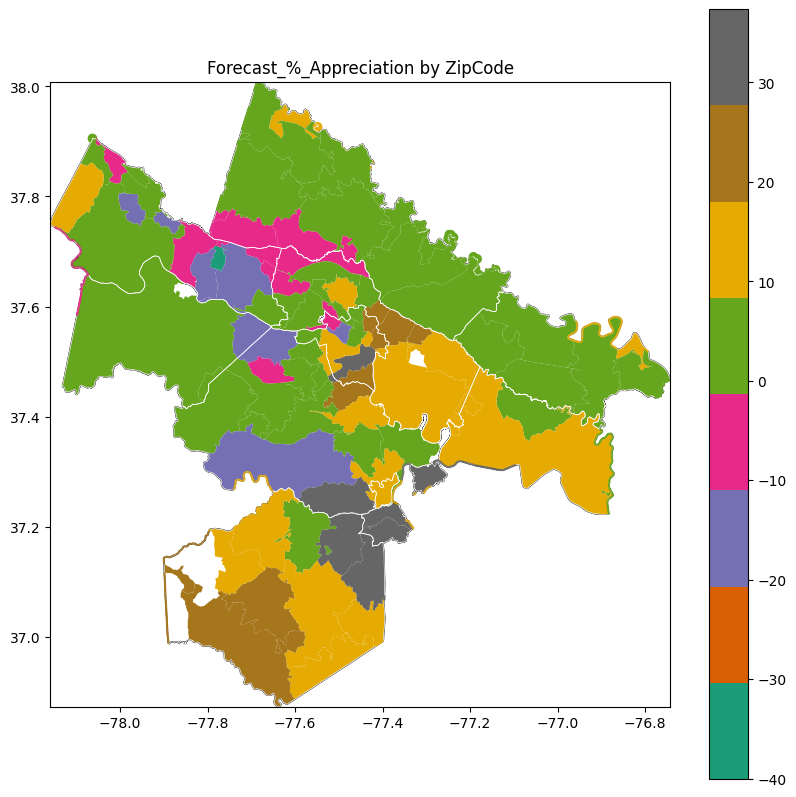

In [642]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge your geodataframe with your results_df
merged_gdf = gdf.merge(prophet_returns_df, on='Zipcode')

#Ensuring gdf zipcodes column is selected for merging
gdf.rename(columns={'GEOID10': 'Zipcode'}, inplace=True)

gdf['Zipcode']=gdf['Zipcode'].astype(int)

# Clipping merged_gdf with gdf_counties
clipped_gdf = gpd.clip(merged_gdf, gdf_counties)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the clipped data
clipped_gdf.plot(column='Forecast_1_Year_%_Appreciation', ax=ax, legend=True, cmap='Dark2')

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# Setting plot limits to the extent of gdf_counties, if desired
minx, miny, maxx, maxy = gdf_counties.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title("Forecast_%_Appreciation by ZipCode")
plt.show()


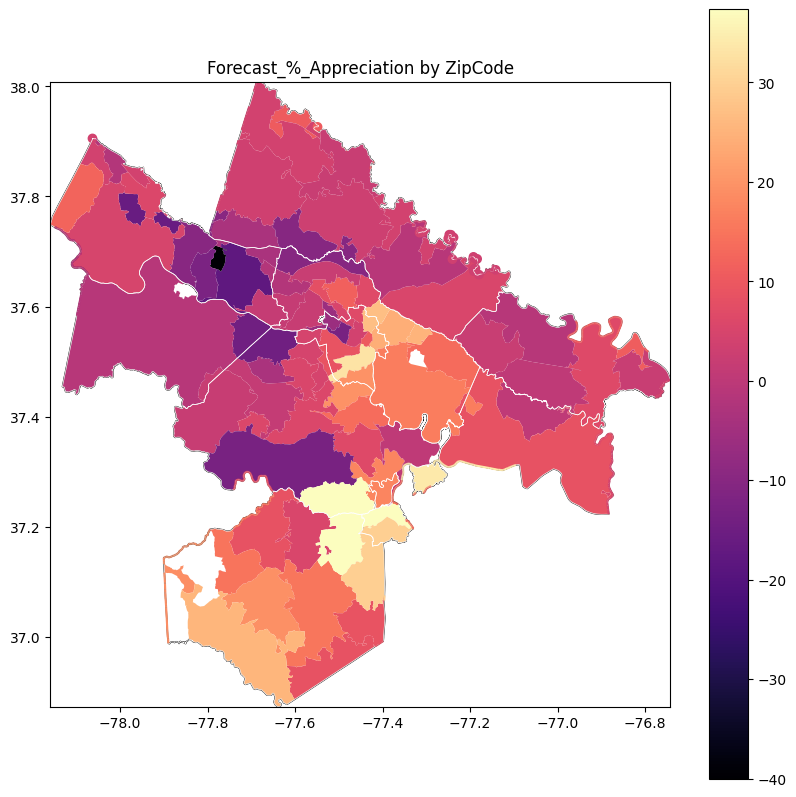

In [644]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge your geodataframe with your results_df
merged_gdf = gdf.merge(prophet_returns_df, on='Zipcode')

#Ensuring gdf zipcodes column is selected for merging
gdf.rename(columns={'GEOID10': 'Zipcode'}, inplace=True)

gdf['Zipcode']=gdf['Zipcode'].astype(int)

# Clipping merged_gdf with gdf_counties
clipped_gdf = gpd.clip(merged_gdf, gdf_counties)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the clipped data
clipped_gdf.plot(column='Forecast_1_Year_%_Appreciation', ax=ax, legend=True, cmap='magma')

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# Setting plot limits to the extent of gdf_counties, if desired
minx, miny, maxx, maxy = gdf_counties.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title("Forecast_%_Appreciation by ZipCode")
plt.show()


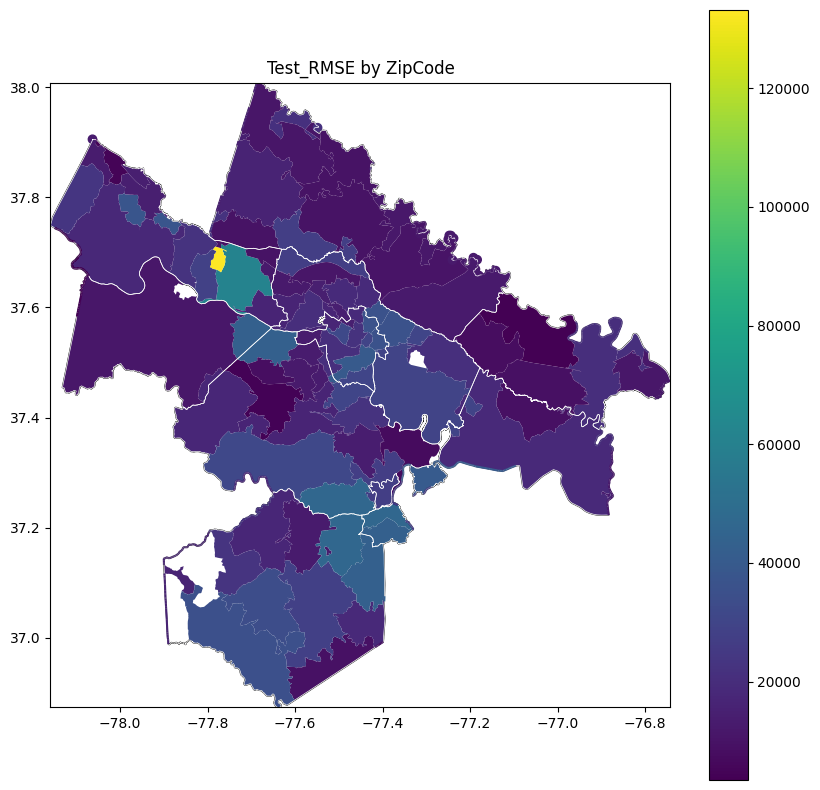

In [643]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge your geodataframe with your results_df
merged_gdf = gdf.merge(prophet_rmse_df, on='Zipcode')

#Ensuring gdf zipcodes column is selected for merging
gdf.rename(columns={'GEOID10': 'Zipcode'}, inplace=True)

gdf['Zipcode']=gdf['Zipcode'].astype(int)

# Clipping merged_gdf with gdf_counties
clipped_gdf = gpd.clip(merged_gdf, gdf_counties)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the clipped data
clipped_gdf.plot(column='Test_RMSE', ax=ax, legend=True, cmap='viridis')

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)

# Setting plot limits to the extent of gdf_counties, if desired
minx, miny, maxx, maxy = gdf_counties.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title("Test_RMSE by ZipCode")
plt.show()


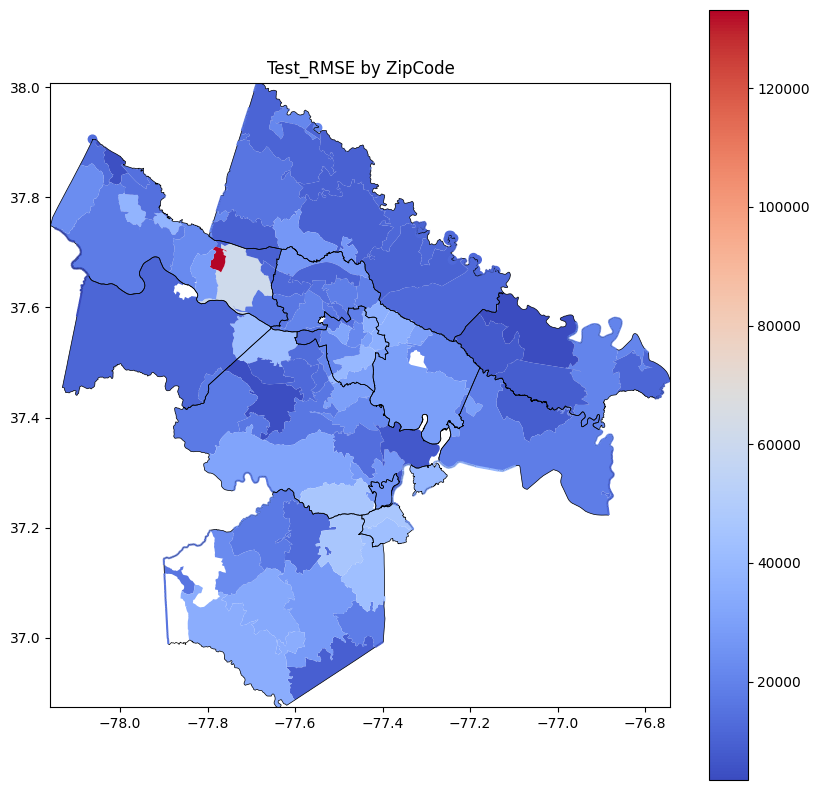

In [386]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge your geodataframe with your results_df
merged_gdf = gdf.merge(prophet_rmse_df, on='Zipcode')

# Clipping merged_gdf with gdf_counties
clipped_gdf = gpd.clip(merged_gdf, gdf_counties)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the clipped data
clipped_gdf.plot(column='Test_RMSE', ax=ax, legend=True, cmap='coolwarm')

# Plot the county boundaries
gdf_counties.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# Setting plot limits to the extent of gdf_counties, if desired
minx, miny, maxx, maxy = gdf_counties.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title("Test_RMSE by ZipCode")
plt.show()


In [387]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming you have a dataframe 'df' and a list of zip codes
# #zip_codes = [23060, 23220, 23221, 23226, 23227]
# colors = ['darkgreen', 'red', 'cornflowerblue', 'silver', 'fuchsia']
# forecast_colors = ['green', 'darkred', 'darkblue', 'dimgrey', 'purple']

# fig, ax = plt.subplots(figsize=(20, 10))

# # Loop through each ZIP code
# for i, zip_code in enumerate(zip_codes):
#     zip_df = format_df(df, zip_code)

#     if zip_df is not None:
#         ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:'2022-01-01'], label=f'z{zip_code} Historical', color=colors[i])

#         # Assuming you have the corresponding Prophet forecast DataFrame for each ZIP code in a dictionary
#         forecast_df = prophet_forecasts[zip_code]
#         ax.plot(forecast_df.set_index('ds').loc['2022-03-30':, 'yhat'], label=f'z{zip_code} Forecast', color=forecast_colors[i])
#         ax.plot(zip_df['Zillow Home Value Index (ZHVI)']['2022-01-31':'2023-12-31'], label=f'z{zip_code} Test', color='orange')
# ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
# ax.set_xlabel('Year', fontsize=12)
# plt.legend()
# ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model')
# plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


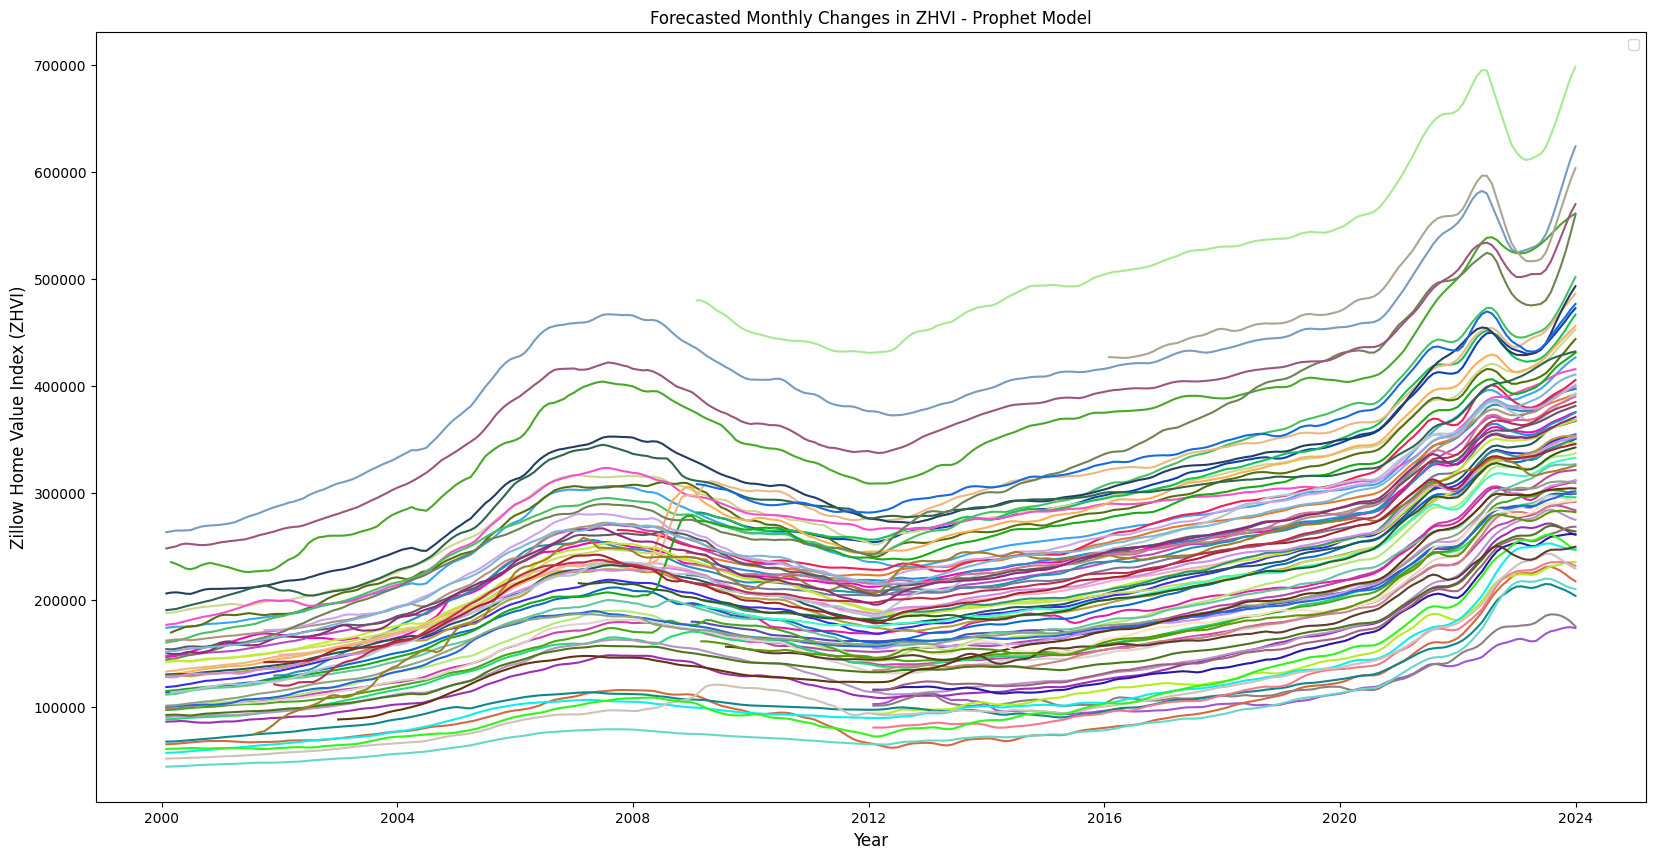

In [388]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def generate_random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

# Assuming you have a dataframe 'df' and a large list of zip codes
#zip_codes = [23060, 23220, 23221, 23226, 23227]  # Replace with your full list of ZIP codes

fig, ax = plt.subplots(figsize=(20, 10))

# Loop through each ZIP code
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None and zip_code in prophet_forecasts:
        historical_color = generate_random_color()
        forecast_color = generate_random_color()
        
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:'2023-12-31'], color=historical_color)

        # Accessing the corresponding Prophet forecast DataFrame for each ZIP code
        #forecast_df = prophet_forecasts[zip_code]
        #ax.plot(forecast_df.set_index('ds').loc['2022-03-30':, 'yhat'], color=forecast_color)

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.legend()
ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model')
plt.show()


In [389]:
## PlanRVA region Zipcodes
zip_codes = gdf_bkg['GEOID10'].astype(int)

zip_codes

0     23089
1     23093
2     23102
3     23103
4     23106
      ...  
80    23038
81    23039
82    23047
83    23059
84    23060
Name: GEOID10, Length: 85, dtype: int32

In [390]:
##Obtaining forecastdate
from datetime import datetime, timedelta

# Initial date string
date_str = split_date

# Convert to datetime object
date_obj = datetime.strptime(date_str, '%Y-%m-%d')

# Add one year
one_year_later = date_obj.replace(year=date_obj.year + 1)
one_year_later

# Convert back to string
forecastdate = one_year_later.strftime('%Y-%m-%d')

print(forecastdate)  # Output: '2023-01-01'

2024-01-01


In [391]:
forecastdate

'2024-01-01'

In [392]:
split_date

'2023-01-01'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


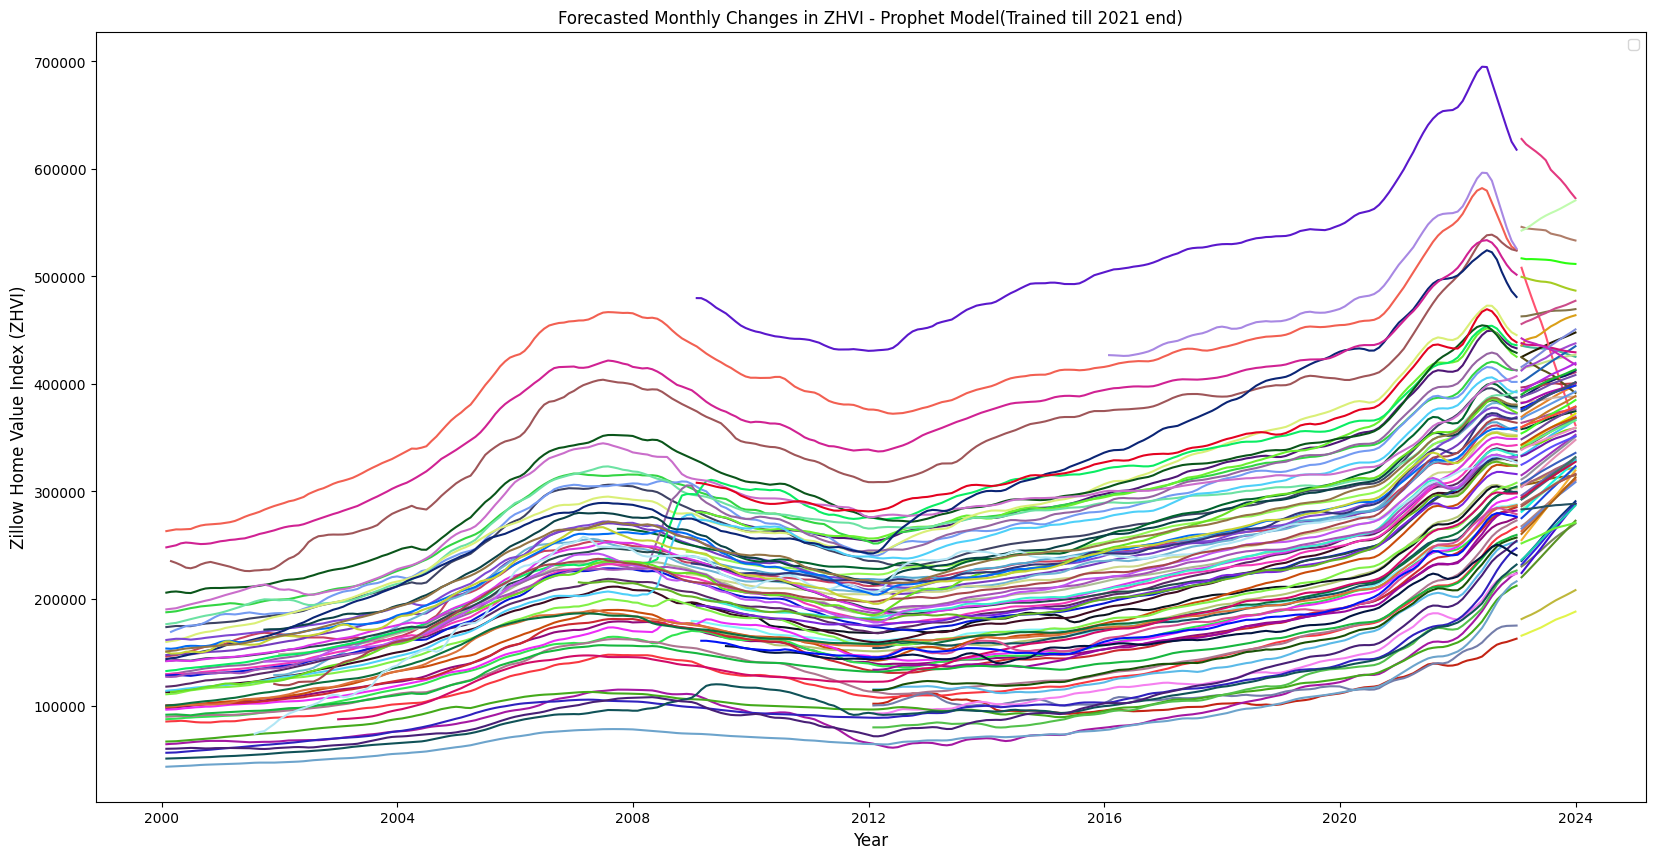

In [393]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def generate_random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

# Assuming you have a dataframe 'df' and a large list of zip codes
#zip_codes = [23060, 23220, 23221, 23226, 23227]  # Replace with your full list of ZIP codes

fig, ax = plt.subplots(figsize=(20, 10))

# Loop through each ZIP code
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None and zip_code in prophet_forecasts:
        historical_color = generate_random_color()
        forecast_color = generate_random_color()
        
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:split_date], color=historical_color)

        # Accessing the corresponding Prophet forecast DataFrame for each ZIP code
        forecast_df = prophet_forecasts[zip_code]
        ax.plot(forecast_df.set_index('ds').loc[split_date:, 'yhat'], color=forecast_color)

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.legend()
ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model(Trained till 2021 end)')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


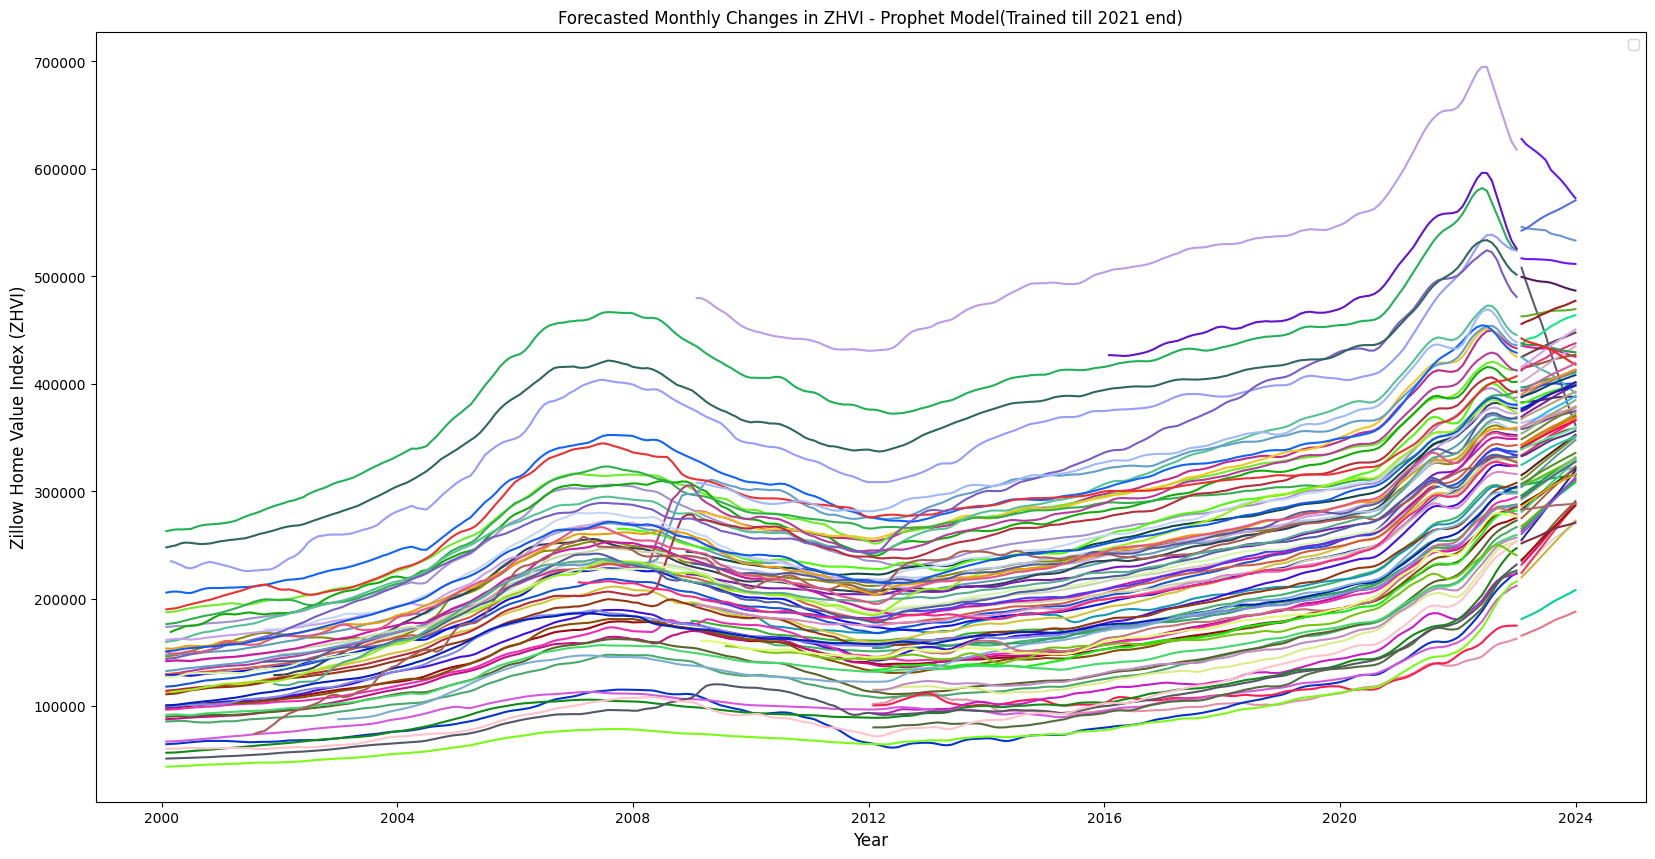

In [394]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def generate_random_color():
    return "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])

# Assuming you have a dataframe 'df' and a large list of zip codes
#zip_codes = [23060, 23220, 23221, 23226, 23227]  # Replace with your full list of ZIP codes

fig, ax = plt.subplots(figsize=(20, 10))

# Loop through each ZIP code
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None and zip_code in prophet_forecasts:
        historical_color = generate_random_color()
        forecast_color = generate_random_color()
        
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:split_date], color=historical_color)

        # Accessing the corresponding Prophet forecast DataFrame for each ZIP code
        forecast_df = prophet_forecasts[zip_code]
        ax.plot(forecast_df.set_index('ds').loc[split_date:, 'yhat'], color=forecast_color)

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.legend()
ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model(Trained till 2021 end)')
plt.show()


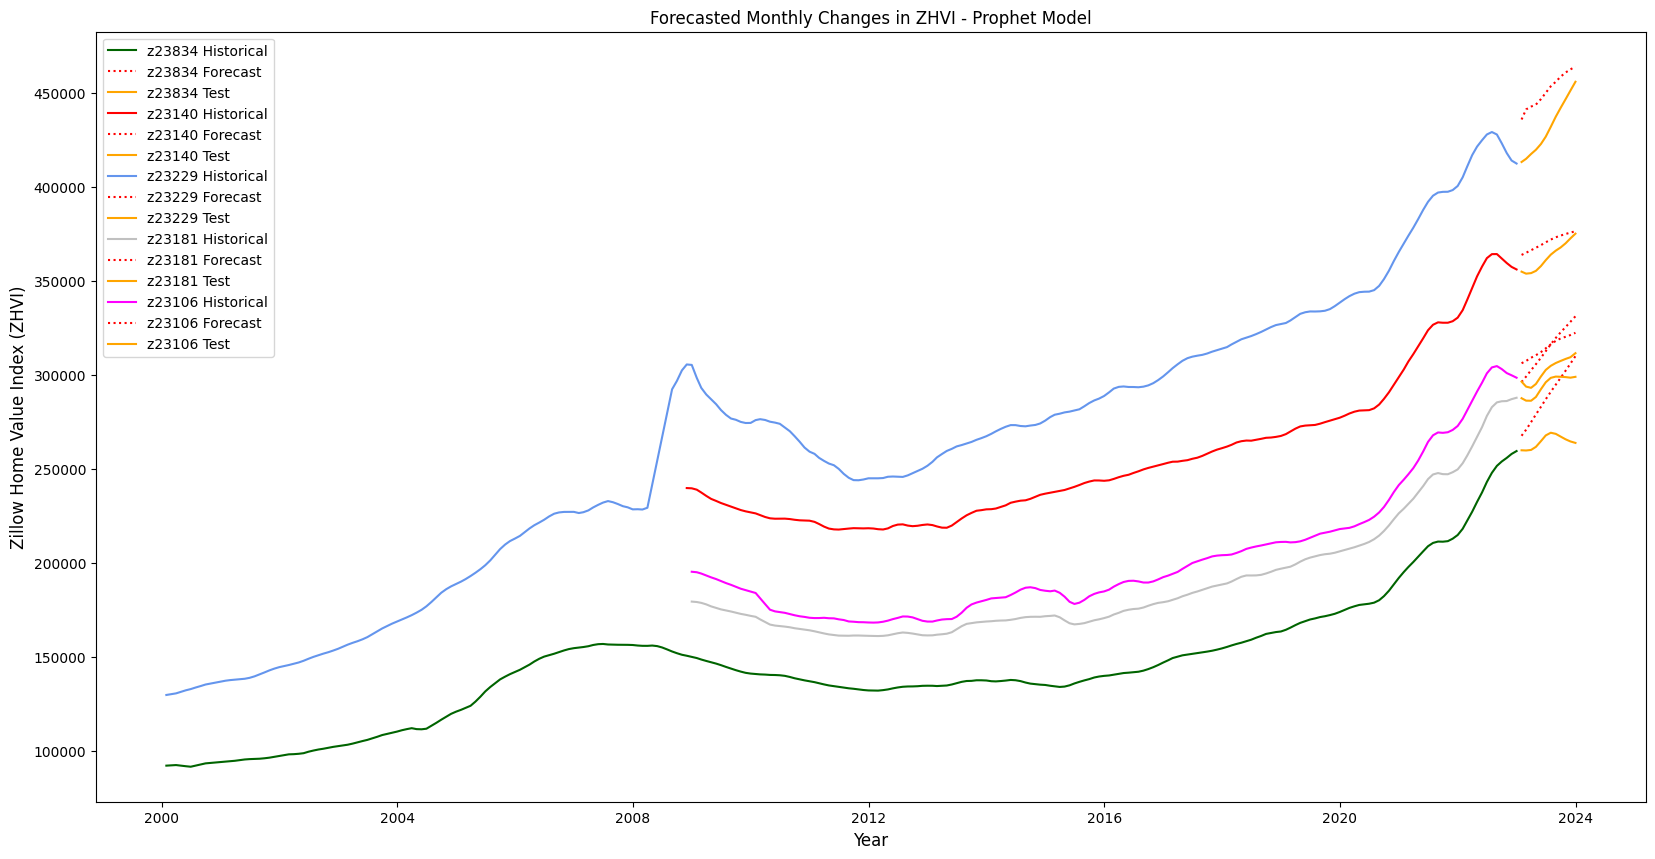

In [395]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Assuming 'df' is your DataFrame and 'GEOID10' is the column with ZIP codes
# Sample 5 random ZIP codes from the DataFrame
random_zip_codes = gdf_bkg['GEOID10'].astype(int).sample(5, random_state=random.randint(0, 10000)).tolist()

colors = ['darkgreen', 'red', 'cornflowerblue', 'silver', 'fuchsia']
forecast_colors = ['green', 'darkred', 'darkblue', 'dimgrey', 'purple']

fig, ax = plt.subplots(figsize=(20, 10))

# Loop through each randomly selected ZIP code
for i, zip_code in enumerate(random_zip_codes):
    zip_df = format_df(df, zip_code)

    if zip_df is not None:
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:split_date], label=f'z{zip_code} Historical', color=colors[i % len(colors)])

        # Assuming you have the corresponding Prophet forecast DataFrame for each ZIP code in a dictionary
        forecast_df = prophet_forecasts[zip_code]
        ax.plot(forecast_df.set_index('ds').loc[split_date:, 'yhat'], label=f'z{zip_code} Forecast', color='red', linestyle='dotted')
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][split_date:forecastdate], label=f'z{zip_code} Test', color='orange')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.legend()
ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model')
plt.show()


In [401]:
prophet_forecasts

{23089:            ds          trend     yhat_lower     yhat_upper    trend_lower  \
 0  2023-01-31  369620.662748  367107.878087  371943.133886  369620.662748   
 1  2023-02-28  372138.921634  370053.114913  375027.014587  372138.921634   
 2  2023-03-31  374926.993973  372570.942048  377995.884882  374898.333297   
 3  2023-04-30  377625.128494  375140.516699  380812.598468  377306.942056   
 4  2023-05-31  380413.200833  377953.232759  383815.469289  379850.964367   
 5  2023-06-30  383111.335354  380449.563645  386360.346843  382187.798757   
 6  2023-07-31  385899.407693  383160.845417  389589.007134  384494.243480   
 7  2023-08-31  388687.480031  385866.814799  392591.493120  386849.053704   
 8  2023-09-30  391385.614552  387947.316275  395868.535560  388903.078100   
 9  2023-10-31  394173.686891  389962.557755  398458.080464  390932.178218   
 10 2023-11-30  396871.821412  392081.209324  401354.733160  392878.439696   
 11 2023-12-31  399659.893751  394259.015813  404515.4823

In [361]:
os.getcwd()

'C:\\Users\\rsingh\\Downloads'

In [364]:
zip_database = pd.read_excel(r"C:\Users\rsingh\OneDrive - PlanRVA\Documents\Time_Series_GrowthProject\zip_code_database.xlsx")

In [365]:
zip_database.head()

zip      type  decommissioned primary_city acceptable_cities  \
0  501    UNIQUE               0   Holtsville               NaN   
1  544    UNIQUE               0   Holtsville               NaN   
2  601  STANDARD               0     Adjuntas               NaN   
3  602  STANDARD               0       Aguada               NaN   
4  603  STANDARD               0    Aguadilla             Ramey   

                                 unacceptable_cities state  \
0                           Internal Revenue Service    NY   
1                           Internal Revenue Service    NY   
2  Colinas Del Gigante, Jard De Adjuntas, Urb San...    PR   
3  Alts De Aguada, Bo Guaniquilla, Comunidad Las ...    PR   
4  Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...    PR   

                county             timezone area_codes world_region country  \
0       Suffolk County     America/New_York        631          NaN      US   
1       Suffolk County     America/New_York        631          NaN      US   
2   Adjuntas Municipio  America/Puerto_Rico   787, 939          NaN      US   
3     Aguada Municipio  America/Puerto_Rico   787, 939          NaN      US   
4  Aguadilla Municipio  America/Puerto_Rico   787, 939          NaN      US   

   latitude  longitude  irs_estimated_population  
0     40.81     -73.04                       562  
1     40.81     -73.04                         0  
2     18.16     -66.72                         0  
3     18.38     -67.18                         0  
4     18.43     -67.15                         0

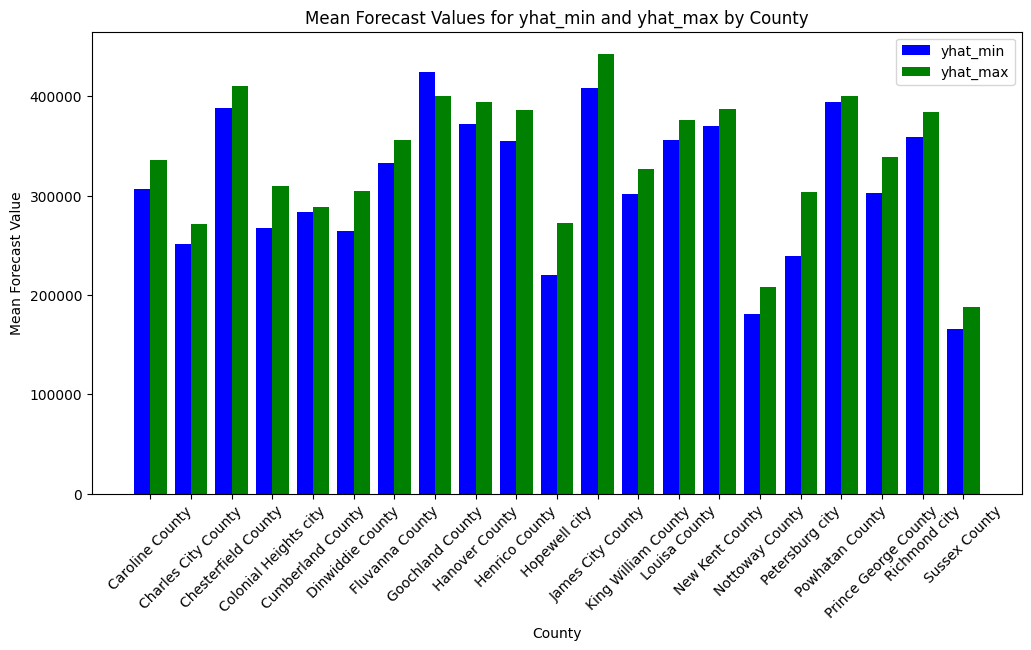

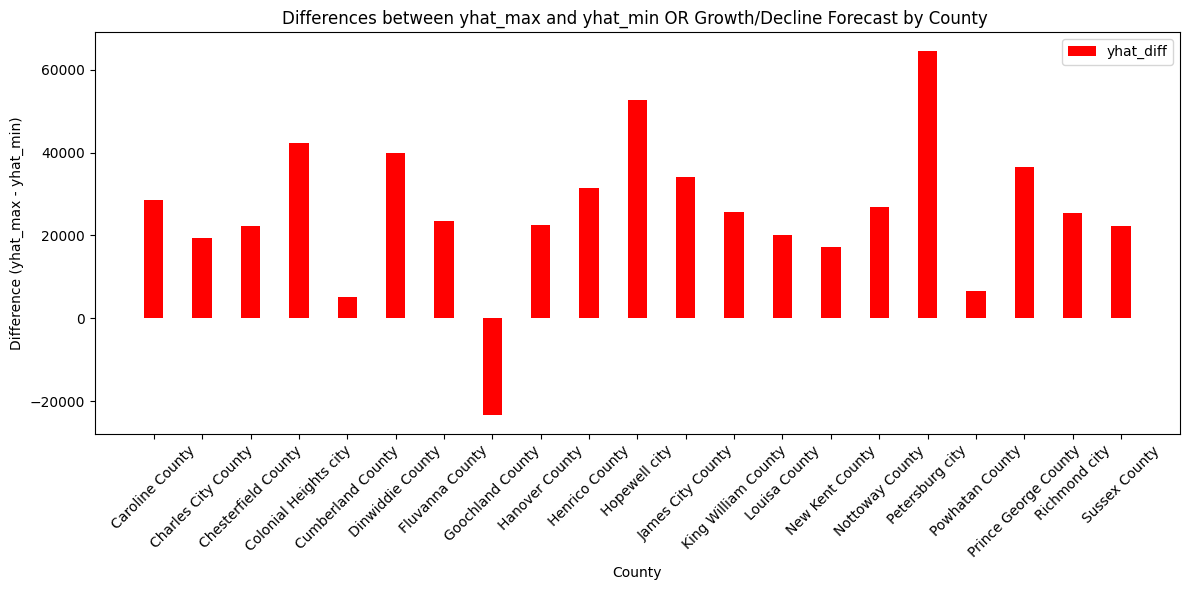

In [435]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame(columns=['zip_code', 'yhat_min', 'yhat_max', 'county'])

# Loop through the ZIP codes and append forecast values to the merged DataFrame
for zip_code in prophet_forecasts.keys():
    if zip_code is not None:
        forecast_df = prophet_forecasts[zip_code]
        county_name = zip_database.loc[zip_database['zip'] == zip_code, 'county'].iloc[0]
        
        # Append forecast values to the merged DataFrame
        merged_df = merged_df.append({'zip_code': zip_code, 'yhat_min': forecast_df['yhat'].iloc[0], 'yhat_max': forecast_df['yhat'].iloc[-1], 'county': county_name}, ignore_index=True)

# Group by county and calculate the mean for each county for 'yhat_min' and 'yhat_max'
county_mean_min_df = merged_df.groupby('county')['yhat_min'].mean().reset_index()
county_mean_max_df = merged_df.groupby('county')['yhat_max'].mean().reset_index()

# Calculate the differences between 'yhat_max' and 'yhat_min'
county_mean_diff_df = county_mean_max_df.copy()
county_mean_diff_df['yhat_diff'] = county_mean_max_df['yhat_max'] - county_mean_min_df['yhat_min']

# Create a bar graph with two bars (yhat_min and yhat_max) for each county
plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.4
index = np.arange(len(county_mean_min_df))

# Bar graph for 'yhat_min'
plt.bar(index, county_mean_min_df['yhat_min'], bar_width, label='yhat_min', color='b', align='center')

# Bar graph for 'yhat_max'
plt.bar(index + bar_width, county_mean_max_df['yhat_max'], bar_width, label='yhat_max', color='g', align='center')

plt.xlabel('County')
plt.ylabel('Mean Forecast Value')
plt.title('Mean Forecast Values for yhat_min and yhat_max by County')
plt.xticks(index + bar_width / 2, county_mean_min_df['county'], rotation=45)
plt.legend()

# Create a new bar graph for the differences (yhat_max - yhat_min)
plt.figure(figsize=(12, 6))

# Bar graph for 'yhat_diff'
plt.bar(index, county_mean_diff_df['yhat_diff'], bar_width, label='yhat_diff', color='r', align='center')

plt.xlabel('County')
plt.ylabel('Difference (yhat_max - yhat_min)')
plt.title('Differences between yhat_max and yhat_min OR Growth/Decline Forecast by County ')
plt.xticks(index, county_mean_diff_df['county'], rotation=45)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [438]:
county_mean_diff_df

county       yhat_max     yhat_diff
0         Caroline County  335814.643752  28631.491426
1     Charles City County  270979.327139  19347.270669
2     Chesterfield County  410150.010561  22332.561814
3   Colonial Heights city  310005.508052  42351.285779
4       Cumberland County  288377.142370   5118.012361
5        Dinwiddie County  304236.128593  39893.953189
6         Fluvanna County  356287.354705  23503.198640
7        Goochland County  400702.237693 -23458.839206
8          Hanover County  394468.358553  22617.672343
9          Henrico County  386032.684766  31494.096930
10          Hopewell city  272717.328606  52613.934771
11      James City County  442898.617278  34054.800698
12    King William County  326797.600488  25560.297990
13          Louisa County  376355.308734  20065.592726
14        New Kent County  387257.750624  17180.197721
15        Nottoway County  208136.589000  26916.115055
16        Petersburg city  304021.601640  64616.589769
17        Powhatan County  400554.846973   6552.486795
18   Prince George County  339163.270955  36394.934495
19          Richmond city  384588.683859  25334.387448
20          Sussex County  188157.040925  22373.080003

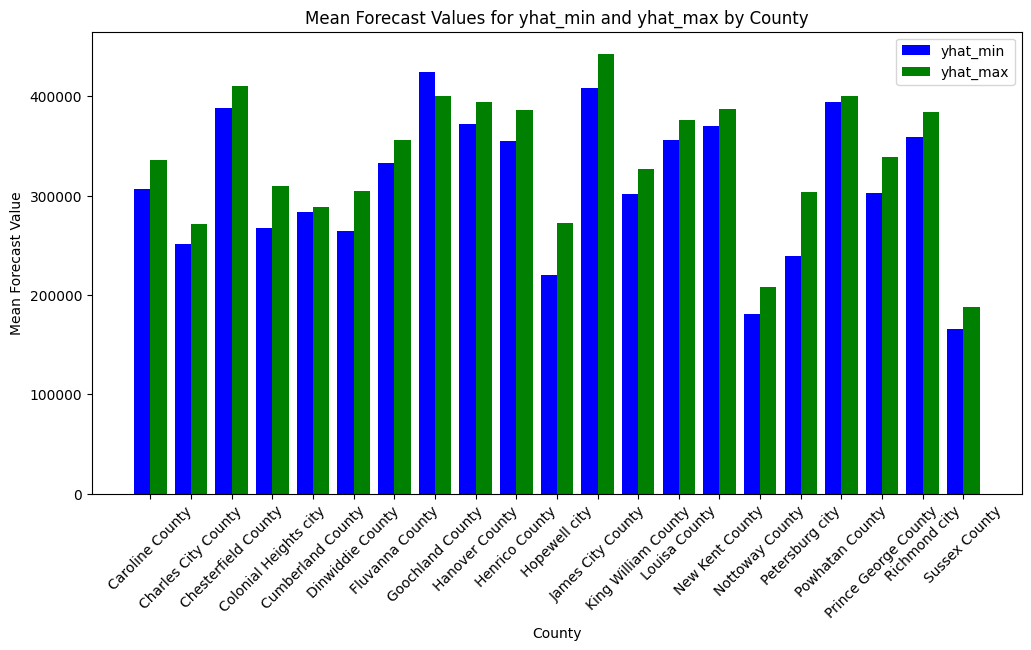

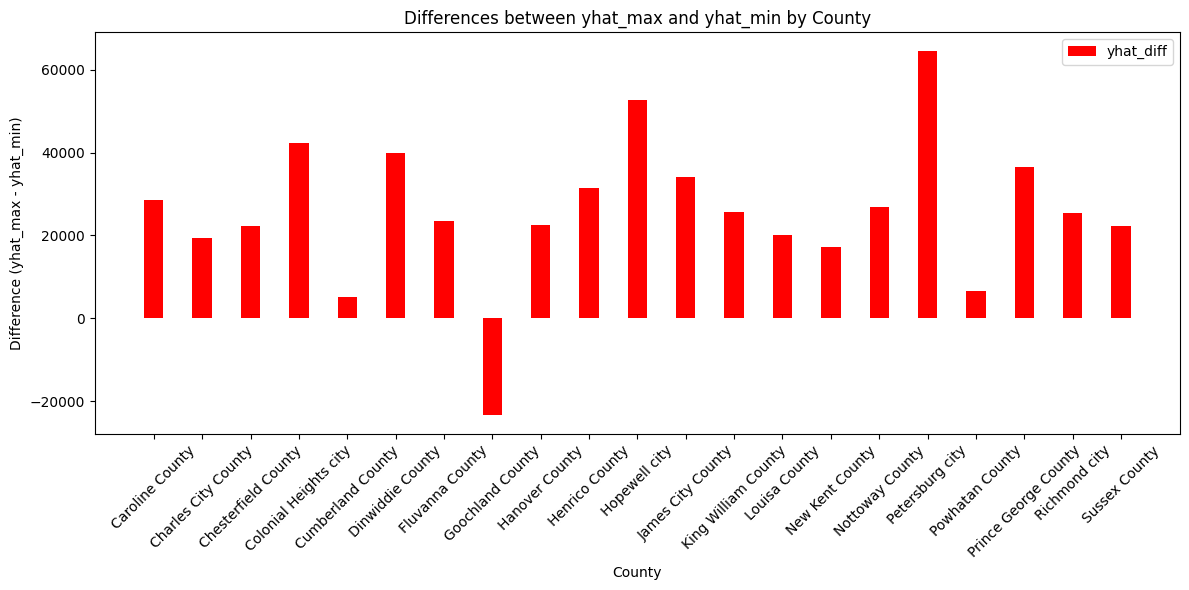

In [650]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create an empty DataFrame to store the merged data
merged_df = pd.DataFrame(columns=['zip_code', 'yhat_min', 'yhat_max', 'county'])

# Loop through the ZIP codes and append forecast values to the merged DataFrame
for zip_code in prophet_forecasts.keys():
    if zip_code is not None:
        forecast_df = prophet_forecasts[zip_code]
        county_name = zip_database.loc[zip_database['zip'] == zip_code, 'county'].iloc[0]
        
        # Append forecast values to the merged DataFrame
        merged_df = merged_df.append({'zip_code': zip_code, 'yhat_min': forecast_df['yhat'].iloc[0], 'yhat_max': forecast_df['yhat'].iloc[-1], 'county': county_name}, ignore_index=True)

# Group by county and calculate the mean for each county for 'yhat_min' and 'yhat_max'
county_mean_min_df = merged_df.groupby('county')['yhat_min'].mean().reset_index()
county_mean_max_df = merged_df.groupby('county')['yhat_max'].mean().reset_index()

# Calculate the differences between 'yhat_max' and 'yhat_min'
county_mean_diff_df = county_mean_max_df.copy()
county_mean_diff_df['yhat_diff'] = county_mean_max_df['yhat_max'] - county_mean_min_df['yhat_min']

# Create a bar graph with two bars (yhat_min and yhat_max) for each county
plt.figure(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.4
index = np.arange(len(county_mean_min_df))

# Bar graph for 'yhat_min'
plt.bar(index, county_mean_min_df['yhat_min'], bar_width, label='yhat_min', color='b', align='center')

# Bar graph for 'yhat_max'
plt.bar(index + bar_width, county_mean_max_df['yhat_max'], bar_width, label='yhat_max', color='g', align='center')

plt.xlabel('County')
plt.ylabel('Mean Forecast Value')
plt.title('Mean Forecast Values for yhat_min and yhat_max by County')
plt.xticks(index + bar_width / 2, county_mean_min_df['county'], rotation=45)
plt.legend()

# Create a new bar graph for the differences (yhat_max - yhat_min)
plt.figure(figsize=(12, 6))

# Bar graph for 'yhat_diff'
plt.bar(index, county_mean_diff_df['yhat_diff'], bar_width, label='yhat_diff', color='r', align='center')

plt.xlabel('County')
plt.ylabel('Difference (yhat_max - yhat_min)')
plt.title('Differences between yhat_max and yhat_min by County')
plt.xticks(index, county_mean_diff_df['county'], rotation=45)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [428]:
forecast_df['yhat'].index[0]

Timestamp('2023-01-31 00:00:00')

In [442]:
## Lets try to create complete time series line graphs for all the counties and then for counties we are interested in. 

In [560]:
prophet_forecasts[zip_code]

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0  2023-01-31  393680.069749  391168.620340  396024.092420  393680.069749   
1  2023-02-28  395900.712669  393125.056647  398224.655038  395900.712669   
2  2023-03-31  398359.281616  395744.253831  400788.679641  398259.103981   
3  2023-04-30  400738.541887  398011.378865  403309.608924  400430.750872   
4  2023-05-31  403197.110834  400641.969919  406185.927825  402556.730183   
5  2023-06-30  405576.371105  402763.852024  408598.936690  404534.387515   
6  2023-07-31  408034.940052  405113.920468  411305.193796  406372.748412   
7  2023-08-31  410493.508998  407321.752125  413929.407807  408336.800882   
8  2023-09-30  412872.769270  408923.542203  416240.574606  410081.405936   
9  2023-10-31  415331.338216  410456.312622  418718.244113  411609.759383   
10 2023-11-30  417710.598488  411706.013830  421325.777679  413436.531396   
11 2023-12-31  420169.167434  413503.586983  424370.849895  415216.337888   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   393680.069749      -44.821192            -44.821192            -44.821192   
1   395900.712669     -290.110292           -290.110292           -290.110292   
2   398447.490228     -112.997805           -112.997805           -112.997805   
3   401020.364452       16.976512             16.976512             16.976512   
4   403736.920197       64.632569             64.632569             64.632569   
5   406443.506924      195.490691            195.490691            195.490691   
6   409295.497379      291.094237            291.094237            291.094237   
7   412281.645815       96.171608             96.171608             96.171608   
8   415068.747774     -254.481546           -254.481546           -254.481546   
9   418184.601271     -630.841917           -630.841917           -630.841917   
10  421363.552568     -775.135729           -775.135729           -775.135729   
11  424499.071068     -735.448037           -735.448037           -735.448037   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   -44.821192    -44.821192    -44.821192                   0.0   
1  -290.110292   -290.110292   -290.110292                   0.0   
2  -112.997805   -112.997805   -112.997805                   0.0   
3    16.976512     16.976512     16.976512                   0.0   
4    64.632569     64.632569     64.632569                   0.0   
5   195.490691    195.490691    195.490691                   0.0   
6   291.094237    291.094237    291.094237                   0.0   
7    96.171608     96.171608     96.171608                   0.0   
8  -254.481546   -254.481546   -254.481546                   0.0   
9  -630.841917   -630.841917   -630.841917                   0.0   
10 -775.135729   -775.135729   -775.135729                   0.0   
11 -735.448037   -735.448037   -735.448037                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                          0.0                         0.0  393635.248557  
1                          0.0                         0.0  395610.602377  
2                          0.0                         0.0  398246.283811  
3                          0.0                         0.0  400755.518399  
4                          0.0                         0.0  403261.743403  
5                          0.0                         0.0  405771.861796  
6                          0.0                         0.0  408326.034289  
7                          0.0                         0.0  410589.680607  
8                          0.0                         0.0  412618.287723  
9                          0.0                         0.0  414700.496299  
10                         0.0                         0.0  416935.462758  
11                         0.0                         0.0  419433.719397

In [ ]:
zip_df = format_df(df, zip_code)

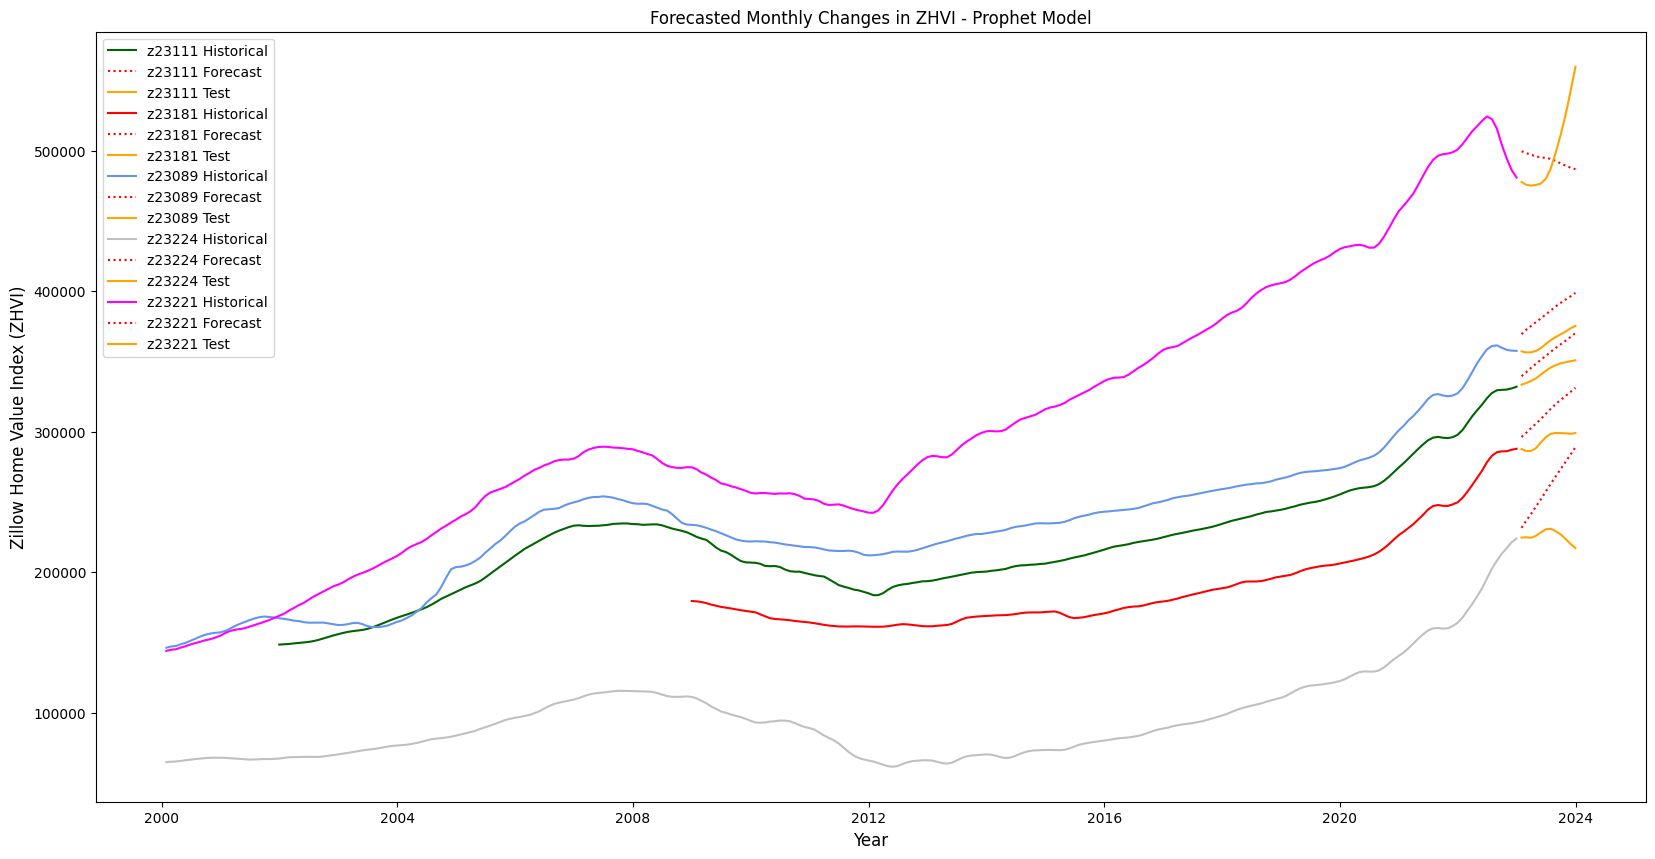

In [645]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Assuming 'df' is your DataFrame and 'GEOID10' is the column with ZIP codes
# Sample 5 random ZIP codes from the DataFrame
random_zip_codes = gdf_bkg['GEOID10'].astype(int).sample(5, random_state=random.randint(0, 10000)).tolist()

colors = ['darkgreen', 'red', 'cornflowerblue', 'silver', 'fuchsia']
forecast_colors = ['green', 'darkred', 'darkblue', 'dimgrey', 'purple']

fig, ax = plt.subplots(figsize=(20, 10))

# Loop through each randomly selected ZIP code
for i, zip_code in enumerate(random_zip_codes):
    zip_df = format_df(df, zip_code)

    if zip_df is not None:
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][:split_date], label=f'z{zip_code} Historical', color=colors[i % len(colors)])

        # Assuming you have the corresponding Prophet forecast DataFrame for each ZIP code in a dictionary
        forecast_df = prophet_forecasts[zip_code]
        ax.plot(forecast_df.set_index('ds').loc[split_date:, 'yhat'], label=f'z{zip_code} Forecast', color='red', linestyle='dotted')
        ax.plot(zip_df['Zillow Home Value Index (ZHVI)'][split_date:forecastdate], label=f'z{zip_code} Test', color='orange')

ax.set_ylabel('Zillow Home Value Index (ZHVI)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
plt.legend()
ax.set_title('Forecasted Monthly Changes in ZHVI - Prophet Model')
plt.show()


In [459]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
       '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
      dtype='object', length=297)

In [483]:
split_date = pd.to_datetime(split_date)

In [484]:
split_date

Timestamp('2023-01-01 00:00:00')

In [654]:
VA_counties=df[df['State']=='VA']['CountyName'].unique()

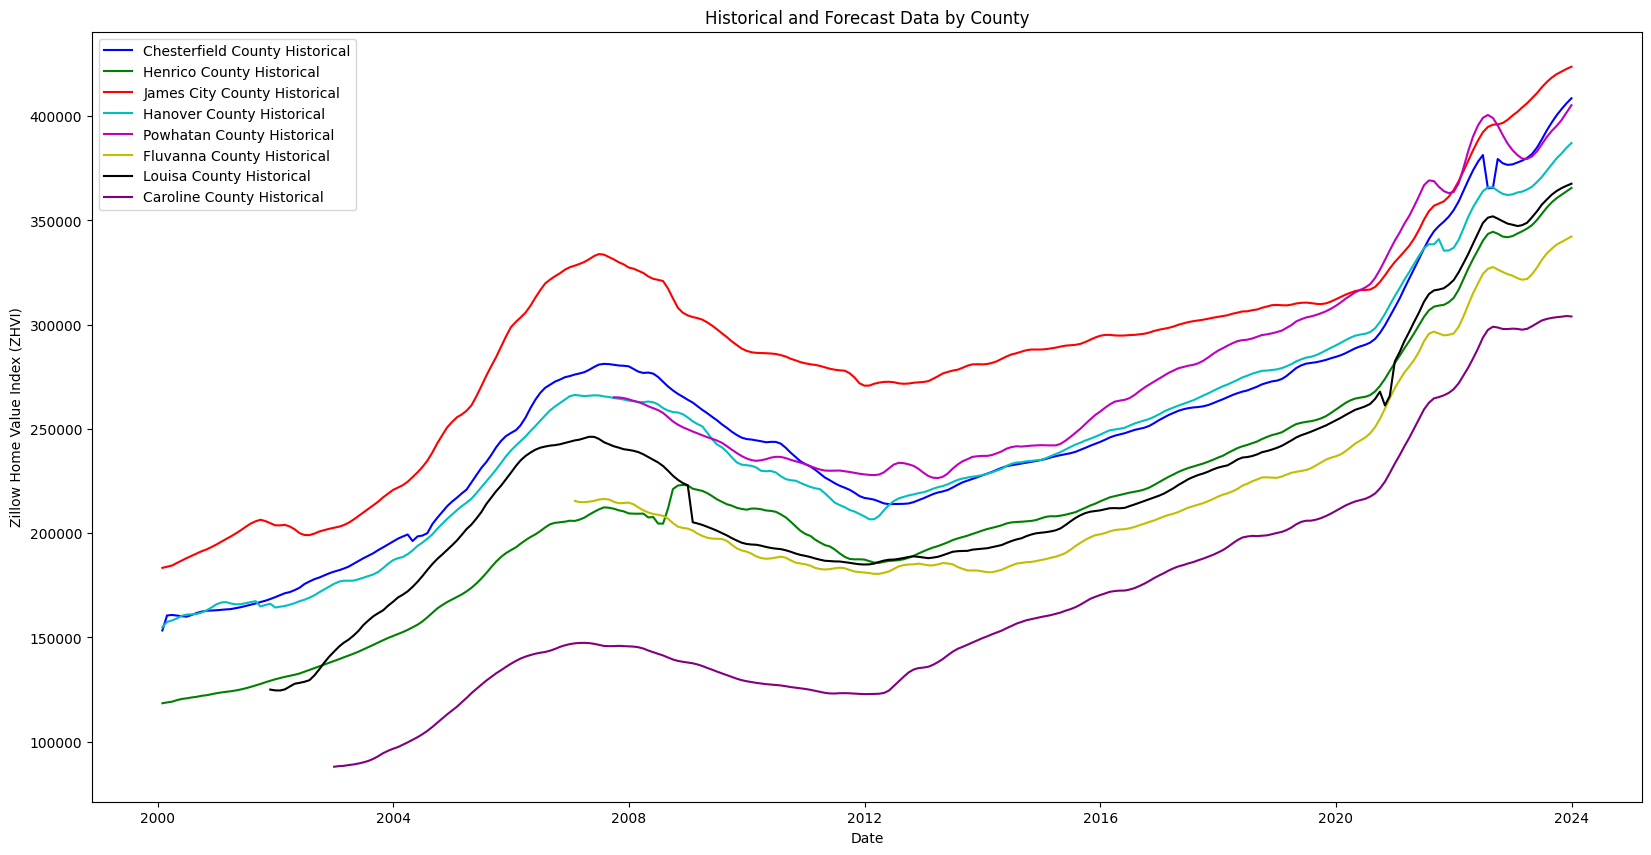

In [661]:
# Create an empty DataFrame to store the merged data
historical_df = pd.DataFrame(columns=['Date', 'ZHVI', 'County'])
forecast_df = pd.DataFrame(columns=['Date', 'yhat', 'County'])

# Loop through the ZIP codes
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None:
        # Loop through each row (index) to filter columns starting with '20'
        for date in zip_df.index:
            try:
                if str(date).startswith('20'):  # Convert date to string and check if it starts with '20'
                    zhvi_value = zip_df.loc[date, 'Zillow Home Value Index (ZHVI)']  # Historical ZHVI value
                    county_name = zip_database.loc[zip_database['zip'] == zip_code, 'county'].iloc[0]  # County name

                    # Check if the date is before or after the split_date
                    historical_df = historical_df.append({'Date': date, 'ZHVI': zhvi_value, 'County': county_name}, ignore_index=True)
            except ValueError as e:
                print(f"Error fitting model for zip code {zip_code}: {e}")
                continue
    else:
        continue

# List of county names you want to plot
counties_to_plot = [county for county in VA_counties if county in historical_df['County'].unique()]

# Create a time series line plot for each selected county with historical and forecast data separated by split_date
fig, ax = plt.subplots(figsize=(20, 10))

custom_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # Replace with your desired colors

for county, color in zip(counties_to_plot, custom_colors):
    county_data = historical_df[historical_df['County'] == county]
    mean_data = county_data.groupby('Date').mean()  # Calculate mean ZHVI for each date
    ax.plot(mean_data.index, mean_data['ZHVI'], label=f'{county} Historical', color=color)

# Convert split_date to string
split_date_str = str(split_date)[:10]
split_date_str = pd.to_datetime(split_date_str)  # Convert it back to datetime

# Add vertical line at the split_date
#ax.axvline(x=split_date_str, color='gray', linestyle='--', label='Split Date')

ax.set_xlabel('Date')
ax.set_ylabel('Zillow Home Value Index (ZHVI)')
ax.set_title('Historical and Forecast Data by County')
plt.legend()
plt.show()


In [658]:
zip_database.head()

zip      type  decommissioned primary_city acceptable_cities  \
0  501    UNIQUE               0   Holtsville               NaN   
1  544    UNIQUE               0   Holtsville               NaN   
2  601  STANDARD               0     Adjuntas               NaN   
3  602  STANDARD               0       Aguada               NaN   
4  603  STANDARD               0    Aguadilla             Ramey   

                                 unacceptable_cities state  \
0                           Internal Revenue Service    NY   
1                           Internal Revenue Service    NY   
2  Colinas Del Gigante, Jard De Adjuntas, Urb San...    PR   
3  Alts De Aguada, Bo Guaniquilla, Comunidad Las ...    PR   
4  Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...    PR   

                county             timezone area_codes world_region country  \
0       Suffolk County     America/New_York        631          NaN      US   
1       Suffolk County     America/New_York        631          NaN      US   
2   Adjuntas Municipio  America/Puerto_Rico   787, 939          NaN      US   
3     Aguada Municipio  America/Puerto_Rico   787, 939          NaN      US   
4  Aguadilla Municipio  America/Puerto_Rico   787, 939          NaN      US   

   latitude  longitude  irs_estimated_population  
0     40.81     -73.04                       562  
1     40.81     -73.04                         0  
2     18.16     -66.72                         0  
3     18.38     -67.18                         0  
4     18.43     -67.15                         0

No forecast data available for zip code 23894


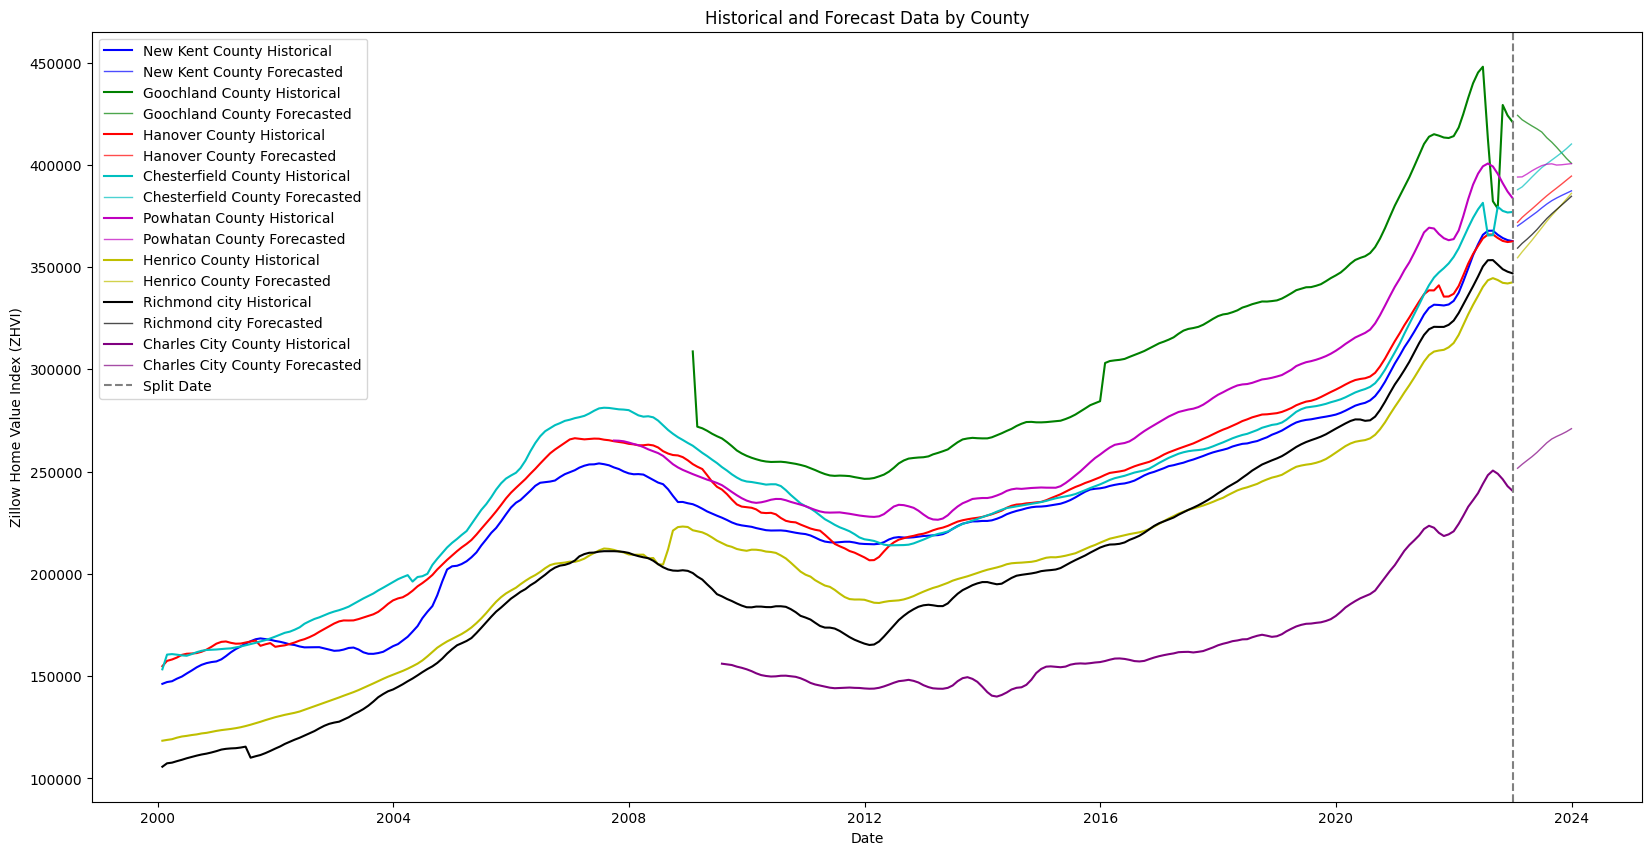

In [598]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt


# Create an empty DataFrame to store the merged data
historical_df = pd.DataFrame(columns=['Date', 'ZHVI', 'County'])
forecast_df = pd.DataFrame(columns=['Date', 'yhat', 'County'])

# Loop through the ZIP codes
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None:
        # Loop through each row (index) to filter columns starting with '20'
        for date in zip_df.index:
            
            try:   
                if str(date).startswith('20'):  # Convert date to string and check if it starts with '20'
                    zhvi_value = zip_df.loc[date, 'Zillow Home Value Index (ZHVI)']  # Historical ZHVI value
                    county_name = zip_database.loc[zip_database['zip'] == zip_code, 'county'].iloc[0]  # County name

                    # Check if the date is before or after the split_date
                    if date <= split_date:
                        historical_df = historical_df.append({'Date': date, 'ZHVI': zhvi_value, 'County': county_name}, ignore_index=True)
                    else:
                        if zip_code in prophet_forecasts:  # Check if the zip_code exists in prophet_forecasts
                            forecast_df_orig = prophet_forecasts[zip_code]
                            forecast_df = forecast_df.append({'Date': date, 'yhat': forecast_df_orig[forecast_df_orig['ds']==date]['yhat'], 'County': county_name}, ignore_index=True)
                        else:
                            print(f"No forecast data available for zip code {zip_code}")
                            continue
            except ValueError as e:
                print(f"Error fitting model for zip code {zip_code}: {e}")
                continue
    else:
        continue

counties_to_plot = ['New Kent County', 
                    'Goochland County', 
                    'Hanover County', 
                    'Chesterfield County', 
                    'Powhatan County', 
                    'Henrico County',
                    'Richmond city', 
                    'Charles City County']  # Replace with your desired county names
#List of county names you want to plot

# Create a time series line plot for each selected county with historical and forecast data separated by split_date
fig, ax = plt.subplots(figsize=(20, 10))

custom_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # Replace with your desired colors

for county, color in zip(counties_to_plot, custom_colors):
    county_data = historical_df[historical_df['County'] == county]
    mean_data = county_data.groupby('Date').mean()  # Calculate mean ZHVI for each date
    ax.plot(mean_data.index, mean_data['ZHVI'], label=f'{county} Historical', color=color)
    
    forecasted_data = forecast_df[forecast_df['County'] == county]
    forecasted_mean_data = forecasted_data.groupby('Date').mean()  # Calculate mean forecasted values for each date
    ax.plot(forecasted_mean_data.index, forecasted_mean_data['yhat'], label=f'{county} Forecasted', linewidth=1.0, color=color, alpha=0.7)

# Convert split_date to string
split_date_str = str(split_date)[:10]
split_date_str = pd.to_datetime(split_date_str)  # Convert it back to datetime

ax.axvline(x=split_date_str, color='gray', linestyle='--', label='Split Date')
ax.set_xlabel('Date')
ax.set_ylabel('Zillow Home Value Index (ZHVI)')
ax.set_title('Historical and Forecast Data by County')
plt.legend()
plt.show()








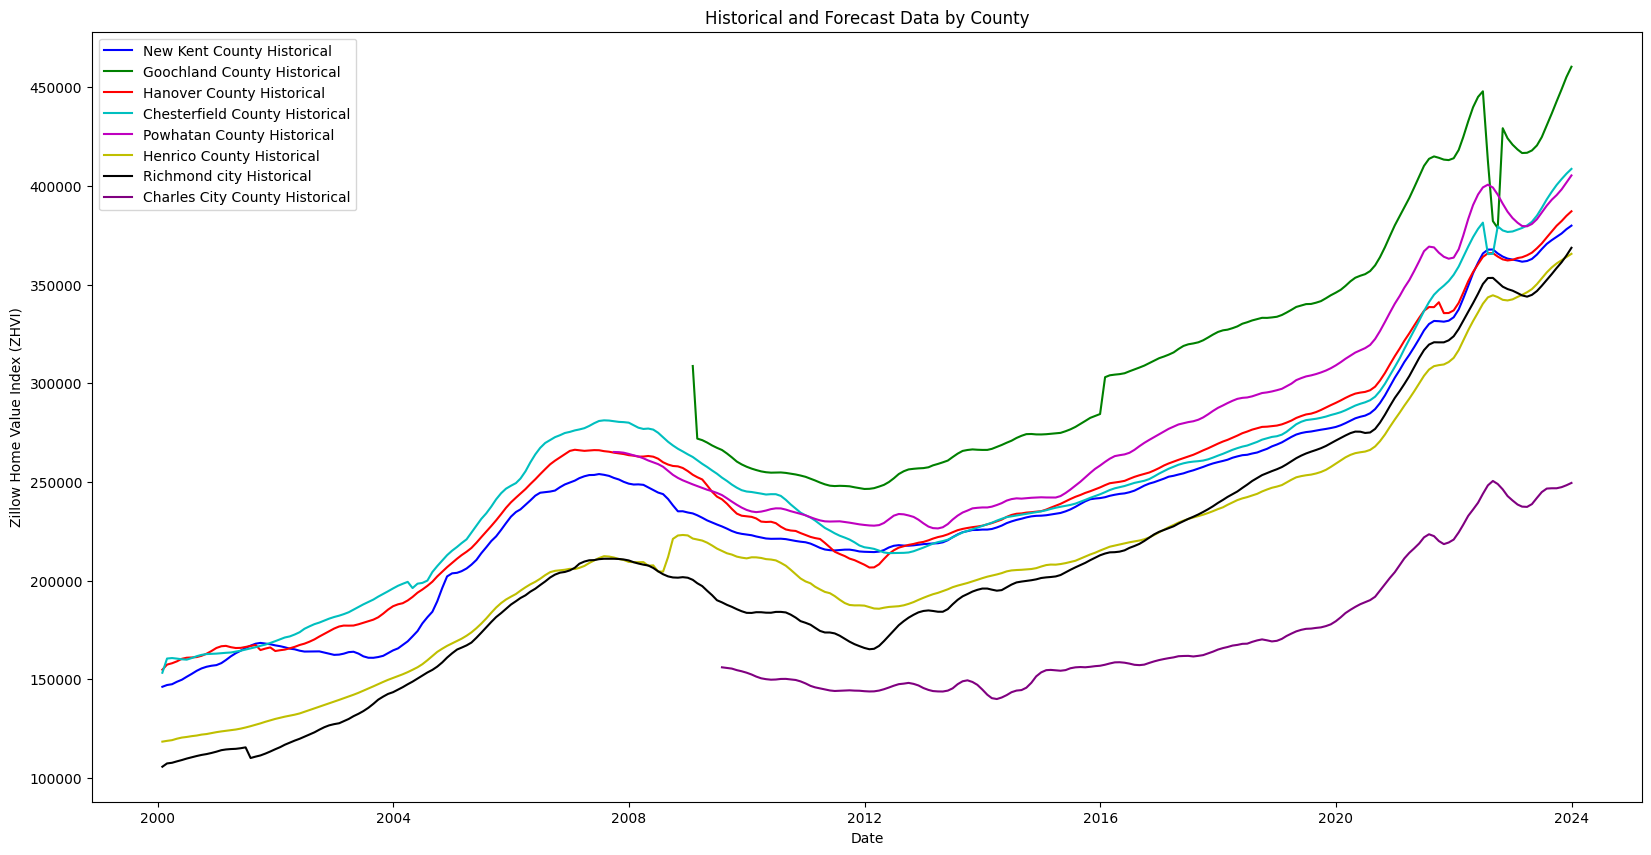

In [659]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt


# Create an empty DataFrame to store the merged data
historical_df = pd.DataFrame(columns=['Date', 'ZHVI', 'County'])
forecast_df = pd.DataFrame(columns=['Date', 'yhat', 'County'])

# Loop through the ZIP codes
for zip_code in zip_codes:
    zip_df = format_df(df, zip_code)

    if zip_df is not None:
        # Loop through each row (index) to filter columns starting with '20'
        for date in zip_df.index:
            
            try:   
                if str(date).startswith('20'):  # Convert date to string and check if it starts with '20'
                    zhvi_value = zip_df.loc[date, 'Zillow Home Value Index (ZHVI)']  # Historical ZHVI value
                    county_name = zip_database.loc[zip_database['zip'] == zip_code, 'county'].iloc[0]  # County name

                    # Check if the date is before or after the split_date
                    
                    historical_df = historical_df.append({'Date': date, 'ZHVI': zhvi_value, 'County': county_name}, ignore_index=True)
                    
            except ValueError as e:
                print(f"Error fitting model for zip code {zip_code}: {e}")
                continue
    else:
        continue

counties_to_plot = ['New Kent County', 
                    'Goochland County', 
                    'Hanover County', 
                    'Chesterfield County', 
                    'Powhatan County', 
                    'Henrico County',
                    'Richmond city', 
                    'Charles City County']  # Replace with your desired county names
#List of county names you want to plot

# Create a time series line plot for each selected county with historical and forecast data separated by split_date
fig, ax = plt.subplots(figsize=(20, 10))

custom_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # Replace with your desired colors

for county, color in zip(counties_to_plot, custom_colors):
    county_data = historical_df[historical_df['County'] == county]
    mean_data = county_data.groupby('Date').mean()  # Calculate mean ZHVI for each date
    ax.plot(mean_data.index, mean_data['ZHVI'], label=f'{county} Historical', color=color)
    
    
# Convert split_date to string
split_date_str = str(split_date)[:10]
split_date_str = pd.to_datetime(split_date_str)  # Convert it back to datetime

#ax.axvline(x=split_date_str, color='gray', linestyle='--', label='Split Date')
ax.set_xlabel('Date')
ax.set_ylabel('Zillow Home Value Index (ZHVI)')
ax.set_title('Historical and Forecast Data by County')
plt.legend()
plt.show()








In [588]:
forecast_df_orig[forecast_df_orig['ds']==date]['yhat']

11    419433.719397
Name: yhat, dtype: float64

In [603]:
end=forecast_df[forecast_df['Date']=='2023-12-31']
end

Date                                            yhat  \
11  2023-12-31  11    398758.047664
Name: yhat, dtype: float64   
23  2023-12-31  11    314983.203627
Name: yhat, dtype: float64   
35  2023-12-31  11    425227.524592
Name: yhat, dtype: float64   
47  2023-12-31  11    572800.205408
Name: yhat, dtype: float64   
59  2023-12-31  11    322394.006514
Name: yhat, dtype: float64   
..         ...                                             ...   
899 2023-12-31  11    316091.936323
Name: yhat, dtype: float64   
911 2023-12-31  11    417971.258223
Name: yhat, dtype: float64   
923 2023-12-31  11    378921.668089
Name: yhat, dtype: float64   
935 2023-12-31  11    511620.635586
Name: yhat, dtype: float64   
947 2023-12-31  11    419433.719397
Name: yhat, dtype: float64   

                  County  
11       New Kent County  
23         Louisa County  
35      Goochland County  
47      Goochland County  
59   King William County  
..                   ...  
899     Goochland County  
911     Goochland County  
923       Hanover County  
935       Henrico County  
947       Henrico County  

[79 rows x 3 columns]

In [607]:
County_Forecasts=end.groupby('County')['yhat'].mean()
County_Forecasts

County
Caroline County          335814.643752
Charles City County      270979.327139
Chesterfield County      410150.010561
Colonial Heights city    310005.508052
Cumberland County        288377.142370
Dinwiddie County         304236.128593
Fluvanna County          356287.354705
Goochland County         400702.237693
Hanover County           394468.358553
Henrico County           386032.684766
Hopewell city            272717.328606
James City County        442898.617278
King William County      326797.600488
Louisa County            376355.308734
New Kent County          387257.750624
Nottoway County          208136.589000
Petersburg city          304021.601640
Powhatan County          400554.846973
Prince George County     339163.270955
Richmond city            384588.683859
Sussex County            188157.040925
Name: yhat, dtype: float64

In [614]:
County_Forecasts.shape

(21,)

In [620]:
selected_rows = County_Forecasts.iloc[[1, 2, 7, 8, 9, 14, 17, 19]]
selected_rows

County
Charles City County    270979.327139
Chesterfield County    410150.010561
Goochland County       400702.237693
Hanover County         394468.358553
Henrico County         386032.684766
New Kent County        387257.750624
Powhatan County        400554.846973
Richmond city          384588.683859
Name: yhat, dtype: float64

In [621]:
County_Forecasts=selected_rows

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


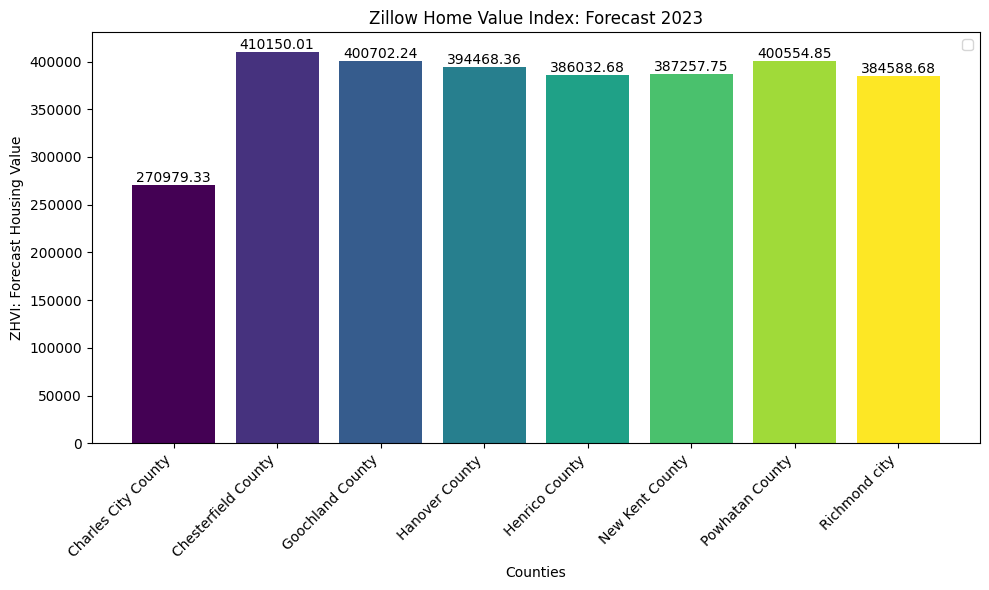

In [624]:
import matplotlib.pyplot as plt
import numpy as np

# Create a color map for bars
colors = plt.cm.viridis(np.linspace(0, 1, len(County_Forecasts)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars with custom colors
bars = ax.bar(County_Forecasts.index, County_Forecasts, color=colors)

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Counties')
ax.set_ylabel('ZHVI: Forecast Housing Value')
ax.set_title('Zillow Home Value Index: Forecast 2023')

# Add data labels above the bars
for bar, value in zip(bars, County_Forecasts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, str(round(value, 2)), ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()


In [641]:
## Final Model values on 2023-12-31
# Charles City County	249501.6535
# Chesterfield County	384100.8146
# Goochland County	460390.7706
# Hanover County	407439.2437
# Henrico County	348575.6725
# New Kent County	370001.631
# Powhatan County	405311.6024
# Richmond City	368649.1078


In [511]:
historical_df.groupby(['Date'])['ZHVI'].mean().reset_index()

Date           ZHVI
0   2000-01-31  127330.398149
1   2000-02-29  130655.002311
2   2000-03-31  130999.640531
3   2000-04-30  131461.723712
4   2000-05-31  131887.418763
..         ...            ...
271 2022-08-31  333057.558892
272 2022-09-30  335170.371724
273 2022-10-31  340610.333732
274 2022-11-30  339920.929841
275 2022-12-31  339839.448645

[276 rows x 2 columns]

In [520]:
historical_df.loc[historical_df['County'] == 'New Kent County'].iloc[:, :2]

Date           ZHVI
0     2000-01-31  146225.673952
1     2000-02-29  147105.826253
2     2000-03-31  147514.417170
3     2000-04-30  148746.645899
4     2000-05-31  149794.745239
...          ...            ...
16360 2022-08-31  372367.543289
16361 2022-09-30  369947.782362
16362 2022-10-31  368496.336948
16363 2022-11-30  367723.343921
16364 2022-12-31  367853.392108

[955 rows x 2 columns]

In [463]:
zip_df

Zillow Home Value Index (ZHVI)  financial_crisis_flag
2000-01-31                   151144.556713                      0
2000-02-29                   151664.810128                      0
2000-03-31                   152108.402130                      0
2000-04-30                   153070.557079                      0
2000-05-31                   153814.965294                      0
...                                    ...                    ...
2023-08-31                   401697.250270                      0
2023-09-30                   404834.836102                      0
2023-10-31                   407219.806150                      0
2023-11-30                   408973.633817                      0
2023-12-31                   410534.627066                      0

[288 rows x 2 columns]

In [489]:
historical_df['County'].unique()

array(['New Kent County', 'Louisa County', 'Goochland County',
       'King William County', 'Hanover County', 'Chesterfield County',
       'Powhatan County', 'Henrico County', 'James City County',
       'Sussex County', 'Dinwiddie County', 'Richmond city',
       'Nottoway County', 'Prince George County', 'Colonial Heights city',
       'Hopewell city', 'Petersburg city', 'Fluvanna County',
       'Caroline County', 'Cumberland County', 'Charles City County'],
      dtype=object)

In [562]:
prophet_forecasts[zip_code]

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0  2023-01-31  393680.069749  391168.620340  396024.092420  393680.069749   
1  2023-02-28  395900.712669  393125.056647  398224.655038  395900.712669   
2  2023-03-31  398359.281616  395744.253831  400788.679641  398259.103981   
3  2023-04-30  400738.541887  398011.378865  403309.608924  400430.750872   
4  2023-05-31  403197.110834  400641.969919  406185.927825  402556.730183   
5  2023-06-30  405576.371105  402763.852024  408598.936690  404534.387515   
6  2023-07-31  408034.940052  405113.920468  411305.193796  406372.748412   
7  2023-08-31  410493.508998  407321.752125  413929.407807  408336.800882   
8  2023-09-30  412872.769270  408923.542203  416240.574606  410081.405936   
9  2023-10-31  415331.338216  410456.312622  418718.244113  411609.759383   
10 2023-11-30  417710.598488  411706.013830  421325.777679  413436.531396   
11 2023-12-31  420169.167434  413503.586983  424370.849895  415216.337888   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   393680.069749      -44.821192            -44.821192            -44.821192   
1   395900.712669     -290.110292           -290.110292           -290.110292   
2   398447.490228     -112.997805           -112.997805           -112.997805   
3   401020.364452       16.976512             16.976512             16.976512   
4   403736.920197       64.632569             64.632569             64.632569   
5   406443.506924      195.490691            195.490691            195.490691   
6   409295.497379      291.094237            291.094237            291.094237   
7   412281.645815       96.171608             96.171608             96.171608   
8   415068.747774     -254.481546           -254.481546           -254.481546   
9   418184.601271     -630.841917           -630.841917           -630.841917   
10  421363.552568     -775.135729           -775.135729           -775.135729   
11  424499.071068     -735.448037           -735.448037           -735.448037   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   -44.821192    -44.821192    -44.821192                   0.0   
1  -290.110292   -290.110292   -290.110292                   0.0   
2  -112.997805   -112.997805   -112.997805                   0.0   
3    16.976512     16.976512     16.976512                   0.0   
4    64.632569     64.632569     64.632569                   0.0   
5   195.490691    195.490691    195.490691                   0.0   
6   291.094237    291.094237    291.094237                   0.0   
7    96.171608     96.171608     96.171608                   0.0   
8  -254.481546   -254.481546   -254.481546                   0.0   
9  -630.841917   -630.841917   -630.841917                   0.0   
10 -775.135729   -775.135729   -775.135729                   0.0   
11 -735.448037   -735.448037   -735.448037                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                          0.0                         0.0  393635.248557  
1                          0.0                         0.0  395610.602377  
2                          0.0                         0.0  398246.283811  
3                          0.0                         0.0  400755.518399  
4                          0.0                         0.0  403261.743403  
5                          0.0                         0.0  405771.861796  
6                          0.0                         0.0  408326.034289  
7                          0.0                         0.0  410589.680607  
8                          0.0                         0.0  412618.287723  
9                          0.0                         0.0  414700.496299  
10                         0.0                         0.0  416935.462758  
11                         0.0                         0.0  419433.719397

In [529]:
new_df=historical_df[historical_df['County']=='Richmond city']

In [541]:
historical_df[historical_df['County'] == county].iloc[:, 1].mean()

202510.76181030678

In [543]:
date

numpy.datetime64('2022-12-31T00:00:00.000000000')

In [547]:
str(date)[:10]


'2022-12-31'

In [628]:
df.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     91982         1       77494        zip        TX    TX      Katy   
1     61148         2        8701        zip        NJ    NJ  Lakewood   
2     91940         3       77449        zip        TX    TX      Katy   
3     62080         4       11368        zip        NY    NY  New York   
4     91733         5       77084        zip        TX    TX   Houston   

                                   Metro        CountyName     2000-01-31  \
0   Houston-The Woodlands-Sugar Land, TX  Fort Bend County  208752.177188   
1  New York-Newark-Jersey City, NY-NJ-PA      Ocean County  133799.965954   
2   Houston-The Woodlands-Sugar Land, TX     Harris County  102327.332899   
3  New York-Newark-Jersey City, NY-NJ-PA     Queens County  147672.475058   
4   Houston-The Woodlands-Sugar Land, TX     Harris County  100957.722364   

   ...     2023-03-31     2023-04-30     2023-05-31     2023-06-30  \
0  ...  468400.012962  469600.790271  471587.869725  474687.471351   
1  ...  517054.419786  521100.063176  526320.736228  532105.809020   
2  ...  274575.011824  273391.851083  272916.706411  273291.932508   
3  ...  480340.864596  473730.902787  466644.010241  461261.507623   
4  ...  267553.019024  266769.398609  266628.259422  267219.988459   

      2023-07-31     2023-08-31     2023-09-30     2023-10-31     2023-11-30  \
0  477460.027392  479919.299106  481726.908022  482958.479293  483644.390919   
1  538056.023382  543798.549494  549960.546654  557112.585902  563739.635747   
2  274045.370378  274933.235990  275461.772882  275451.663963  275219.130604   
3  459443.414913  459437.482269  458881.548977  456860.171677  453514.767036   
4  268054.762069  268918.974834  269342.669492  269333.119699  268917.017812   

      2023-12-31  
0  484254.484150  
1  568385.787815  
2  274931.001539  
3  449239.710048  
4  268499.368493  

[5 rows x 297 columns]

In [627]:
zip_database

zip      type  decommissioned primary_city acceptable_cities  \
0        501    UNIQUE               0   Holtsville               NaN   
1        544    UNIQUE               0   Holtsville               NaN   
2        601  STANDARD               0     Adjuntas               NaN   
3        602  STANDARD               0       Aguada               NaN   
4        603  STANDARD               0    Aguadilla             Ramey   
...      ...       ...             ...          ...               ...   
42730  99926    PO BOX               0   Metlakatla               NaN   
42731  99927    PO BOX               0  Point Baker               NaN   
42732  99928    PO BOX               0    Ward Cove               NaN   
42733  99929    PO BOX               0     Wrangell               NaN   
42734  99950    PO BOX               0    Ketchikan  Edna Bay, Kasaan   

                                     unacceptable_cities state  \
0                               Internal Revenue Service    NY   
1                               Internal Revenue Service    NY   
2      Colinas Del Gigante, Jard De Adjuntas, Urb San...    PR   
3      Alts De Aguada, Bo Guaniquilla, Comunidad Las ...    PR   
4      Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...    PR   
...                                                  ...   ...   
42730                                                NaN    AK   
42731                                                NaN    AK   
42732                                                NaN    AK   
42733                                                NaN    AK   
42734                                                NaN    AK   

                                        county             timezone  \
0                               Suffolk County     America/New_York   
1                               Suffolk County     America/New_York   
2                           Adjuntas Municipio  America/Puerto_Rico   
3                             Aguada Municipio  America/Puerto_Rico   
4                          Aguadilla Municipio  America/Puerto_Rico   
...                                        ...                  ...   
42730        Prince of Wales-Hyder Census Area   America/Metlakatla   
42731        Prince of Wales-Hyder Census Area        America/Sitka   
42732                Ketchikan Gateway Borough        America/Sitka   
42733                Wrangell City and Borough        America/Sitka   
42734  Prince of Wales-Outer Ketchikan Borough        America/Sitka   

                    area_codes world_region country  latitude  longitude  \
0                          631          NaN      US     40.81     -73.04   
1                          631          NaN      US     40.81     -73.04   
2                     787, 939          NaN      US     18.16     -66.72   
3                     787, 939          NaN      US     18.38     -67.18   
4                     787, 939          NaN      US     18.43     -67.15   
...                        ...          ...     ...       ...        ...   
42730                      907          NaN      US     55.14    -131.49   
42731                      907          NaN      US     56.33    -133.61   
42732                      907          NaN      US     55.45    -131.79   
42733  236, 250, 672, 778, 907          NaN      US     56.41    -131.61   
42734                      907          NaN      US     55.34    -131.64   

       irs_estimated_population  
0                           562  
1                             0  
2                             0  
3                             0  
4                             0  
...                         ...  
42730                      1140  
42731                        48  
42732                      1530  
42733                      2145  
42734                       262  

[42735 rows x 15 columns]

In [629]:
df_2=df
df2.renamecolumns{'zip':'RegionName',inplace = True}

SyntaxError: ':' expected after dictionary key (1226323960.py, line 2)

In [ ]:
zip_merge = pd.merge(df2,zip_database,on='zip')

In [632]:
# Assuming you have already loaded your dataframes df and zip_database

# Create a copy of df for renaming columns
df2 = df.copy()

# Rename the 'zip' column to 'RegionName' and convert it to int
df2.rename(columns={'zip': 'RegionName'}, inplace=True)
df2['RegionName'] = df2['RegionName'].astype(int)

# Convert the 'zip' column in zip_database to int
zip_database['zip'] = zip_database['zip'].astype(int)

# Merge df2 with zip_database on the 'RegionName' column
zip_merge = pd.merge(df2, zip_database, left_on='RegionName', right_on='zip')

# Drop the duplicate 'zip' column if needed
zip_merge.drop(columns=['zip'], inplace=True)

In [634]:
zip_merge.shape

(26354, 311)

In [635]:
zip_merge.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000-01-31',
       ...
       'unacceptable_cities', 'state', 'county', 'timezone', 'area_codes',
       'world_region', 'country', 'latitude', 'longitude',
       'irs_estimated_population'],
      dtype='object', length=311)

In [637]:
os.getcwd()

'C:\\Users\\rsingh\\Downloads'

In [638]:
# Save the merged dataframe to an Excel file
output_excel_file = 'merged_data.xlsx'
zip_merge.to_excel(output_excel_file, index=False)

print(f"Data merged and saved to {output_excel_file}")

Data merged and saved to merged_data.xlsx
